In [ ]:
# Cargamos las librerías
import pandas as pd
import numpy as np
from IPython.display import display

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Leemos la base de datos
df = pd.read_excel("/content/drive/MyDrive/2026-0/Machine Learing para Finanzas/Trabajo 1/income_dataset.xlsx")

In [ ]:
# Realizamos la diferenciación de variables continuas y categóricas
num_cols = df.select_dtypes(include="number").columns.tolist()
cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Definimos nuestra variable dependiente (Target)
TARGET = "Income"
if TARGET in num_cols:
    num_cols.remove(TARGET)

# **1. Análisis Estadístico Inicial: DESCRIPTIVO**

## **1.1 Variables numéricas**

In [ ]:
# Estadísticos descriptivos: Count, media, desvest, min, max y percentiles.
desc_num = df[num_cols].describe().T
display(desc_num)

,count,mean,std,min,25%,50%,75%,max
Age,10000.0,44.0217,15.203998,18.0,31.0,44.0,57.0,70.0
Number_of_Dependents,10000.0,2.5270,1.713991,0.0,1.0,3.0,4.0,5.0
Work_Experience,10000.0,24.8588,14.652622,0.0,12.0,25.0,37.0,50.0
Household_Size,10000.0,3.9896,2.010496,1.0,2.0,4.0,6.0,7.0


In [ ]:
# Cuantiles
quantiles = df[num_cols].quantile([0.01,0.05,0.10,0.25,0.5,0.75,0.9,0.95,0.99]).T
display(quantiles)

,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99
Age,18.0,20.0,23.0,31.0,44.0,57.0,65.0,68.0,70.0
Number_of_Dependents,0.0,0.0,0.0,1.0,3.0,4.0,5.0,5.0,5.0
Work_Experience,0.0,2.0,4.0,12.0,25.0,37.0,45.0,48.0,50.0
Household_Size,1.0,1.0,1.0,2.0,4.0,6.0,7.0,7.0,7.0


In [ ]:
# % Missing
missing_num = df[num_cols].isna().mean() *100
missing_num = missing_num.sort_values(ascending=False).to_frame("% NA")
display(missing_num)

,% NA
Age,0.0
Number_of_Dependents,0.0
Work_Experience,0.0
Household_Size,0.0


In [ ]:
# Top 5 valores más frecuentes
for col in num_cols:
    print(f"\nTop 5 valores más frecuentes de {col}")

    top5 = (
        df[col]
        .value_counts(normalize=True, dropna=False)
        .mul(100)
        .head(5)
        .to_frame(name="% sobre el total de Obs")
        .reset_index()
    )

    display(
        top5
        .style
        .hide(axis="index")
        .set_properties(**{"text-align": "center"})
        .format({"% sobre el total de Obs": "{:.2f}"})
    )


Top 5 valores más frecuentes de Age


Age,% sobre el total de Obs
43,2.23
66,2.16
62,2.15
40,2.12
64,2.09



Top 5 valores más frecuentes de Number_of_Dependents


Number_of_Dependents,% sobre el total de Obs
5,17.45
3,17.12
1,16.51
0,16.42
4,16.29



Top 5 valores más frecuentes de Work_Experience


Work_Experience,% sobre el total de Obs
2,2.24
44,2.21
48,2.19
24,2.18
33,2.16



Top 5 valores más frecuentes de Household_Size


Household_Size,% sobre el total de Obs
1,14.77
3,14.45
6,14.37
7,14.33
5,14.11


## **1.2 Variables Categóricas**

In [ ]:
# Cardinalidad
card_cat = df[cat_cols].nunique(dropna=False).sort_values(ascending=False).to_frame(name="Cardinalidad").reset_index().rename(columns={"index": "Variables categóricas"})

display(
    card_cat
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
)

Variables categóricas,Cardinalidad
Occupation,5
Education_Level,4
Primary_Mode_of_Transportation,4
Marital_Status,3
Location,3
Employment_Status,3
Type_of_Housing,3
Homeownership_Status,2
Gender,2


In [ ]:
# Top 10 valores más frecuentes
for col in cat_cols:
    print(f"\nTop 10 valores más frecuentes de {col}")

    abs_count = df[col].value_counts(dropna=False).rename("Total")
    rel_count = (
        df[col]
        .value_counts(normalize=True, dropna=False)
        .mul(100)
        .rename("% sobre el total")
    )

    top10 = (
        pd.concat([abs_count, rel_count], axis=1)
        .head(10)
        .reset_index()
        .rename(columns={"index": col})
    )

    display(
        top10
        .style
        .hide(axis="index")
        .set_properties(**{"text-align": "center"})
        .format({"% sobre el total": "{:.2f}"})
    )


Top 10 valores más frecuentes de Education_Level


Education_Level,Total,% sobre el total
Bachelor's,4058,40.58
High School,2959,29.59
Master's,2482,24.82
Doctorate,501,5.01



Top 10 valores más frecuentes de Occupation


Occupation,Total,% sobre el total
Healthcare,3035,30.35
Technology,2407,24.07
Finance,1525,15.25
Others,1521,15.21
Education,1512,15.12



Top 10 valores más frecuentes de Location


Location,Total,% sobre el total
Urban,7037,70.37
Suburban,1951,19.51
Rural,1012,10.12



Top 10 valores más frecuentes de Marital_Status


Marital_Status,Total,% sobre el total
Married,5136,51.36
Single,3900,39.00
Divorced,964,9.64



Top 10 valores más frecuentes de Employment_Status


Employment_Status,Total,% sobre el total
Full-time,5004,50.04
Part-time,3016,30.16
Self-employed,1980,19.80



Top 10 valores más frecuentes de Homeownership_Status


Homeownership_Status,Total,% sobre el total
Own,6018,60.18
Rent,3982,39.82



Top 10 valores más frecuentes de Type_of_Housing


Type_of_Housing,Total,% sobre el total
Single-family home,4055,40.55
Apartment,4001,40.01
Townhouse,1944,19.44



Top 10 valores más frecuentes de Gender


Gender,Total,% sobre el total
Male,5123,51.23
Female,4877,48.77



Top 10 valores más frecuentes de Primary_Mode_of_Transportation


Primary_Mode_of_Transportation,Total,% sobre el total
Public transit,4047,40.47
Car,2986,29.86
Biking,1940,19.40
Walking,1027,10.27


## **1.3 Target**

In [ ]:
#Realizamos una verificación sobre el tipo de variable y el número de observaciones.
target_overview = pd.DataFrame({
    "Target": [TARGET],
    "Tipo de dato": [df[TARGET].dtype],
    "Observaciones totales": [df.shape[0]],
    "Observaciones nulas": [df[TARGET].isna().sum()],
    "% Nulos": [df[TARGET].isna().mean() * 100]
})


display(
    target_overview
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .format({"% Nulos": "{:.2f}"})
)

Target,Tipo de dato,Observaciones totales,Observaciones nulas,% Nulos
Income,int64,10000,0,0.00


In [ ]:
#Estadísticos descriptivos del target
desc_income = (
    df[TARGET]
    .describe()
    .to_frame()
    .T
)

display(desc_income)

,count,mean,std,min,25%,50%,75%,max
Income,10000.0,816838.1667,1.821089e+06,31044.0,68446.0,72943.0,350667.5,9992571.0


In [ ]:
#Cuantiles
quantiles_income = (
    df[TARGET]
    .quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99])
    .to_frame()
    .T
)

quantiles_income.index = [TARGET]

display(quantiles_income)

,0.01,0.05,0.10,0.25,0.50,0.75,0.90,0.95,0.99
Income,36121.95,64149.7,65766.0,68446.0,72943.0,350667.5,2890510.4,5343905.45,8836918.82


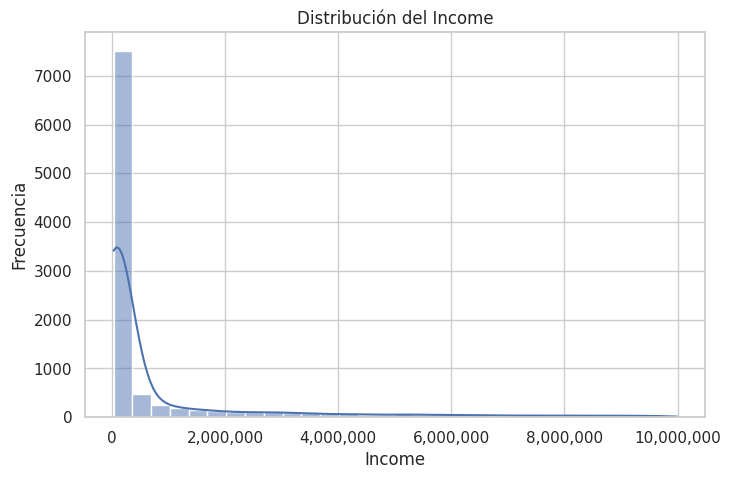

In [ ]:
#Distribución del Income
plt.figure(figsize=(8, 5))
sns.histplot(df[TARGET], bins=30, kde=True)

plt.gca().xaxis.set_major_formatter(
    mtick.StrMethodFormatter('{x:,.0f}')
)

plt.title("Distribución del Income")
plt.xlabel("Income")
plt.ylabel("Frecuencia")
plt.show()


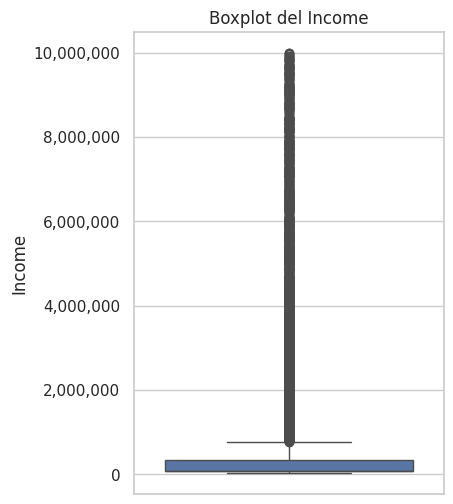

% de outliers : 19.31% de la muestra
Valor extremo mínimo: 31044
Valor extremo máximo: 9992571
Observaciones con Income igual o menor a 0: 0


In [ ]:
#Distribución del Income
plt.figure(figsize=(4, 6))
sns.boxplot(y=df[TARGET])

plt.gca().yaxis.set_major_formatter(
    mtick.StrMethodFormatter('{x:,.0f}')
)

plt.title("Boxplot del Income")
plt.ylabel("Income")
plt.show()

#Outliers
Q1 = df[TARGET].quantile(0.25)
Q3 = df[TARGET].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_pct = (
    ((df[TARGET] < lower_bound) | (df[TARGET] > upper_bound))
    .mean() * 100
)

print(f"% de outliers : {outliers_pct:.2f}% de la muestra")
print(f"Valor extremo mínimo: {df[TARGET].min()}")
print(f"Valor extremo máximo: {df[TARGET].max()}")
print(f"Observaciones con Income igual o menor a 0: {(df[TARGET] <= 0).sum()}")

# **2. Análisis de calidad - DIAGNÓSTICO**

### ¿La data es confiable, usable y coherente para un modelo de regresión de ingresos?

In [ ]:
# Dtypes incorrectos
print(f"Observaciones: {df.shape[0]}")
print(f"Variables: {df.shape[1]}")


dtype_summary = (
    df.dtypes
    .to_frame(name="Tipo de dato")
    .reset_index()
    .rename(columns={"index": "Variable"})
)

display(
    dtype_summary
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
)

Observaciones: 10000
Variables: 14


Variable,Tipo de dato
Age,int64
Education_Level,object
Occupation,object
Number_of_Dependents,int64
Location,object
Work_Experience,int64
Marital_Status,object
Employment_Status,object
Household_Size,int64
Homeownership_Status,object


## **2.1 Variables numéricas**

In [ ]:
# Coerce diagnóstico
coerce_check = {}
for col in num_cols:
    before_na = df[col].isna().sum()
    after_na = pd.to_numeric(df[col], errors="coerce").isna().sum()
    coerce_check[col] = [before_na, after_na]

coerce_df = pd.DataFrame(coerce_check, index=["NaN Iniciales", "NaN Finales"]).T
display(coerce_df
        .style
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ]))

,NaN Iniciales,NaN Finales
Age,0,0
Number_of_Dependents,0,0
Work_Experience,0,0
Household_Size,0,0


In [ ]:
# Missing reales
missings = df[num_cols].isna().mean().sort_values(ascending=False)

summary = (
    missings
    .to_frame(name="Missings Reales")
    .reset_index()
    .rename(columns={"index": "Variable"})
)

display(
    summary
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({"Missings Reales": "{:.0f}"})
)

Variable,Missings Reales
Age,0
Number_of_Dependents,0
Work_Experience,0
Household_Size,0


In [ ]:
# Outliers
outliers = df[num_cols].agg(["min", lambda x: x.quantile(0.01), "median", lambda x: x.quantile(0.99), "max"]).T
outliers.columns = ["MIN", "P1", "P50", "P99", "MAX"]

outliers = (
    outliers
    .reset_index()
    .rename(columns={"index": "Variable"})
)
display(
    outliers
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({
        "MIN": "{:.2f}",
        "P1": "{:.2f}",
        "P50": "{:.2f}",
        "P99": "{:.2f}",
        "MAX": "{:.2f}"
    })
)

Variable,MIN,P1,P50,P99,MAX
Age,18.00,18.00,44.00,70.00,70.00
Number_of_Dependents,0.00,0.00,3.00,5.00,5.00
Work_Experience,0.00,0.00,25.00,50.00,50.00
Household_Size,1.00,1.00,4.00,7.00,7.00


## **2.2 Variables categóricas**

In [ ]:
# Missing explícito
cat_missing = (
    df[cat_cols]
    .isna()
    .agg(["sum", "mean"])
    .T
    .rename(columns={
        "sum": "Nulos",
        "mean": "% Nulos"
    })
)

cat_missing["% Nulos"] *= 100

cat_missing = (
    cat_missing
    .reset_index()
    .rename(columns={"index": "Variable"})
)

display(
    cat_missing
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({"% Nulos": "{:.2f}", "Nulos":"{:.0f}"})
)

Variable,Nulos,% Nulos
Education_Level,0,0.00
Occupation,0,0.00
Location,0,0.00
Marital_Status,0,0.00
Employment_Status,0,0.00
Homeownership_Status,0,0.00
Type_of_Housing,0,0.00
Gender,0,0.00
Primary_Mode_of_Transportation,0,0.00


In [ ]:
#Missing Codificado
# Definir tokens de missing codificado
missing_tokens = [
    "unknown", "none", "missing", "na", "n/a", "?", "other", ""
]

# Inicializar DataFrame base
encoded_missing_df = pd.DataFrame(
    0,
    index=cat_cols,
    columns=missing_tokens
)

# Poblar la tabla
for col in cat_cols:
    col_values = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
    )

    for token in missing_tokens:
        encoded_missing_df.loc[col, token] = (col_values == token).sum()

# Formato final
encoded_missing_df = (
    encoded_missing_df
    .reset_index()
    .rename(columns={"index": "Variable"})
)

display(
    encoded_missing_df
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
)

Variable,unknown,none,missing,na,n/a,?,other,
Education_Level,0,0,0,0,0,0,0,0
Occupation,0,0,0,0,0,0,0,0
Location,0,0,0,0,0,0,0,0
Marital_Status,0,0,0,0,0,0,0,0
Employment_Status,0,0,0,0,0,0,0,0
Homeownership_Status,0,0,0,0,0,0,0,0
Type_of_Housing,0,0,0,0,0,0,0,0
Gender,0,0,0,0,0,0,0,0
Primary_Mode_of_Transportation,0,0,0,0,0,0,0,0


In [ ]:
# Categorías con baja frecuencia
low_freq_summary = []

for col in cat_cols:
    freq = df[col].value_counts(normalize=True, dropna=False)

    low_freq = freq[freq < 0.01]

    low_freq_summary.append({
        "Variable": col,
        "N° categorías": freq.shape[0],
        "Categorías con frecuencia <1%": low_freq.shape[0],
        "% Obs en categorías <1%": low_freq.sum() * 100
    })

low_freq_df = pd.DataFrame(low_freq_summary)

display(
    low_freq_df
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({"% Obs en categorías <1%": "{:.2f}"})
)


Variable,N° categorías,Categorías con frecuencia <1%,% Obs en categorías <1%
Education_Level,4,0,0.00
Occupation,5,0,0.00
Location,3,0,0.00
Marital_Status,3,0,0.00
Employment_Status,3,0,0.00
Homeownership_Status,2,0,0.00
Type_of_Housing,3,0,0.00
Gender,2,0,0.00
Primary_Mode_of_Transportation,4,0,0.00


In [ ]:
#Valores inesperados consolidado

unexpected_table = []

for col in cat_cols:
    values = (df[col].astype(str).str.strip().str.lower().unique())

    unexpected_table.append({
        "Variable": col,
        "N° categorías únicas": len(values),
        "Categorías observadas": ", ".join(sorted(values))
    })

unexpected_df = pd.DataFrame(unexpected_table)

display(
    unexpected_df
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
)


Variable,N° categorías únicas,Categorías observadas
Education_Level,4,"bachelor's, doctorate, high school, master's"
Occupation,5,"education, finance, healthcare, others, technology"
Location,3,"rural, suburban, urban"
Marital_Status,3,"divorced, married, single"
Employment_Status,3,"full-time, part-time, self-employed"
Homeownership_Status,2,"own, rent"
Type_of_Housing,3,"apartment, single-family home, townhouse"
Gender,2,"female, male"
Primary_Mode_of_Transportation,4,"biking, car, public transit, walking"


In [ ]:
#Valores inesperados con frecuencia
for col in cat_cols:
    values_df = (
        df[col]
        .astype(str)
        .str.strip()
        .str.lower()
        .value_counts(dropna=False)
        .to_frame(name="Frecuencia")
        .reset_index()
        .rename(columns={"index": "Categoría"})
    )

    print(f"\nValores observados en {col}")
    display(
        values_df
        .style
        .hide(axis="index")
        .set_properties(**{"text-align": "center"})
    )



Valores observados en Education_Level


Education_Level,Frecuencia
bachelor's,4058
high school,2959
master's,2482
doctorate,501



Valores observados en Occupation


Occupation,Frecuencia
healthcare,3035
technology,2407
finance,1525
others,1521
education,1512



Valores observados en Location


Location,Frecuencia
urban,7037
suburban,1951
rural,1012



Valores observados en Marital_Status


Marital_Status,Frecuencia
married,5136
single,3900
divorced,964



Valores observados en Employment_Status


Employment_Status,Frecuencia
full-time,5004
part-time,3016
self-employed,1980



Valores observados en Homeownership_Status


Homeownership_Status,Frecuencia
own,6018
rent,3982



Valores observados en Type_of_Housing


Type_of_Housing,Frecuencia
single-family home,4055
apartment,4001
townhouse,1944



Valores observados en Gender


Gender,Frecuencia
male,5123
female,4877



Valores observados en Primary_Mode_of_Transportation


Primary_Mode_of_Transportation,Frecuencia
public transit,4047
car,2986
biking,1940
walking,1027


# **3. Preprocesamiento**

Preparamos los datos para el modelo de regresión de ingresos, garantizando:

*   Consistencia
*   Manejo adecuado de valores missings
*   Tratamiento adecuado de variables categóricas
*   Reproductibilidad

## **3.1 Variables numéricas**

### **3.1.1 Imputación de valores**

*   De acuerdo al diagnóstico, el dataset actual no cuenta con valores nulos (NaN).
*   Sin embargo, la imputación se realiza para garantizar que el pipeline se encuentre matemáticamente bien definido para cualquier entrada válida.
*   A futuro, si en el dataset aparecen observaciones con valores nulos, el pipeline ya se encuentra preparado para tratarlas. Esto permite que el modelo sea más robusto y reutilizable.

Esto permite que el modelo esté definido para cualquier observación que respete el esquema de datos, incluso si esa observación tiene valores nulos.

In [ ]:
#Generamos una copia de nuestro df para tener la versión preprocesada

df_num_processed = df.copy()

#Imputamos los valores nulos sin escalado.
num_imputer = SimpleImputer(strategy="median")

df_num_processed[num_cols] = num_imputer.fit_transform(
    df_num_processed[num_cols])

### **3.1.2 Aplicación de LOG**

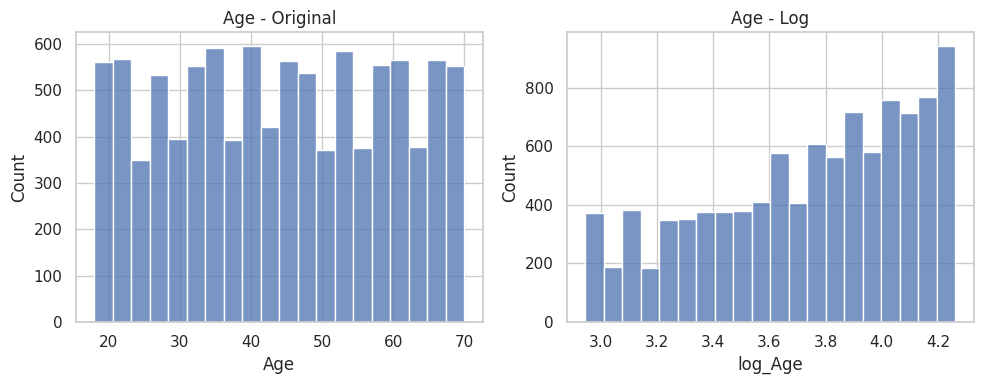

In [ ]:
#Testeamos para Age
df_log_test2 = df_num_processed.copy()

log_candidates = ["Age"]

for col in log_candidates:
    df_log_test2[f"log_{col}"] = np.log1p(df_log_test2[col])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df[col], bins=20, ax=axes[0])
axes[0].set_title(f"{col} - Original")

sns.histplot(df_log_test2[f"log_{col}"], bins=20, ax=axes[1])
axes[1].set_title(f"{col} - Log")

plt.tight_layout()
plt.show()


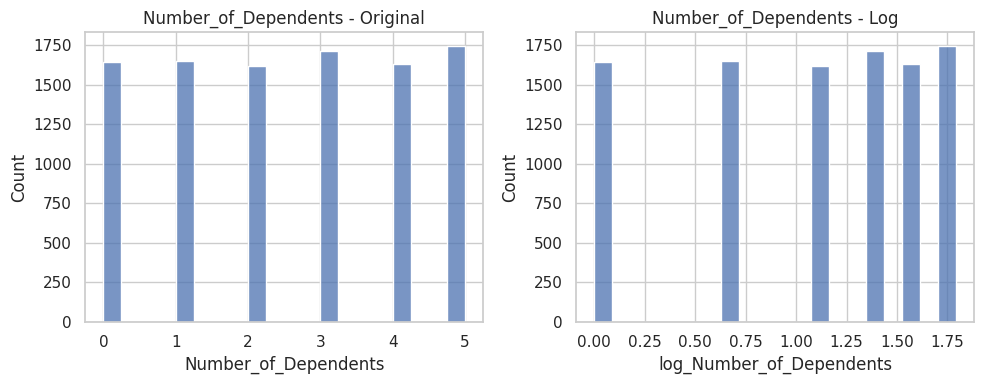

In [ ]:
#Testeamos para Number_of_Dependents
df_log_test3 = df_num_processed.copy()

log_candidates = ["Number_of_Dependents"]

for col in log_candidates:
    df_log_test3[f"log_{col}"] = np.log1p(df_log_test3[col])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df[col], bins=20, ax=axes[0])
axes[0].set_title(f"{col} - Original")

sns.histplot(df_log_test3[f"log_{col}"], bins=20, ax=axes[1])
axes[1].set_title(f"{col} - Log")

plt.tight_layout()
plt.show()


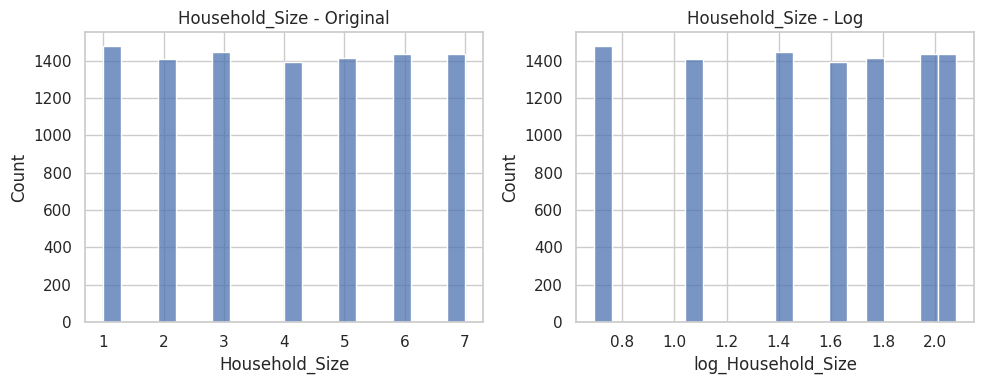

In [ ]:
#Testeamos para Household_Size
df_log_test4 = df_num_processed.copy()

log_candidates = ["Household_Size"]

for col in log_candidates:
    df_log_test4[f"log_{col}"] = np.log1p(df_log_test4[col])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df[col], bins=20, ax=axes[0])
axes[0].set_title(f"{col} - Original")

sns.histplot(df_log_test4[f"log_{col}"], bins=20, ax=axes[1])
axes[1].set_title(f"{col} - Log")

plt.tight_layout()
plt.show()


Se evaluó la implementación de transformaciones logarítmicas sobre las variables numéricas. No obstante, el análisis demostró que dichas variables presentan de por si rangos acotados, una naturaleza discreta y ausencia de colas extremas. Además, en la mayoría de los casos, la transformación logarítmica introdujo mayor asimetría sin mejorar la estructura distributiva con respecto a la distribución original.

Por ello, se decidió no aplicar transformaciones logarítmicas sobre las variables.

## **3.2 Variables categóricas**

### **3.2.1 Limpieza de Strip**

In [ ]:
#Limpieza de los string y estandarización para eliminar espacios ocultos y asegurar consistencia.
df_cat_clean = df_num_processed.copy()

for col in cat_cols:
    df_cat_clean[col] = (
        df_cat_clean[col]
        .astype(str)
        .str.strip()
        .str.lower()
    )

### **3.2.2 Imputamos Missings**

*   De acuerdo al diagnóstico, el dataset actual no cuenta con valores nulos (NaN) ni nulos codificados.
*   Sin embargo, la imputación se realiza para garantizar que el pipeline se encuentre matemáticamente bien definido para cualquier entrada válida.
*   A futuro, si en el dataset aparecen observaciones con valores nulos, el pipeline ya se encuentra preparado para tratarlas. Esto permite que el modelo sea más robusto y reutilizable.

Esto permite que el modelo esté definido para cualquier observación que respete el esquema de datos, incluso si esa observación tiene valores nulos y nulos codificados.

In [ ]:
#Imputamos missing codificados
missing_tokens = [
    "unknown", "none", "missing", "na", "n/a", "?", "other", ""
]

df_cat_clean[cat_cols] = df_cat_clean[cat_cols].replace(
    missing_tokens,
    np.nan
)

#Imputamos missings
cat_imputer = SimpleImputer(strategy="most_frequent")

df_cat_clean[cat_cols] = cat_imputer.fit_transform(
    df_cat_clean[cat_cols]
)



## **3.3 Target**

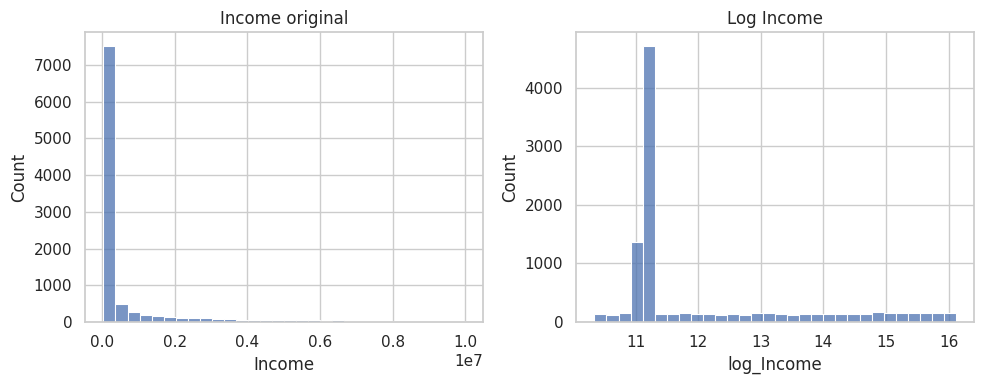

In [ ]:
#Aplicamos una transformación logística
df_processed = df_cat_clean.copy()
df_processed["log_Income"] = np.log1p(df_processed["Income"])

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.histplot(df_processed["Income"], bins=30, ax=axes[0])
axes[0].set_title("Income original")

sns.histplot(df_processed["log_Income"], bins=30, ax=axes[1])
axes[1].set_title("Log Income")

plt.tight_layout()
plt.show()

La variable Income presenta una distribución asimétrica con una cola derecha extensa. Por ello, ase aplicó la transformación logarítmica a modo de reducir la asimetría y la influencia de valores extremos. Estoy permite que la variable sea más adecuada para el modelado de la regresión.

# **4. Análisis Exploratorio EDA Univariado: Análisis Ex-Antes y Ex-post**

In [ ]:
df_raw = df.copy()          # Dataset Ex Ante
df_prep = df_processed.copy()  # Dataset Ex Post

## **4.1 Variables numéricas**

### **4.1.1 Estadísticos Descriptivos**

In [ ]:
# Ex ante
desc_num_raw = (
    df_raw[num_cols]
    .describe()
    .T
    .reset_index()
    .rename(columns={"index": "Variable"})
)

desc_num_raw["Etapa"] = "Ex ante"

# Ex post
desc_num_prep = (
    df_prep[num_cols]
    .describe()
    .T
    .reset_index()
    .rename(columns={"index": "Variable"})
)

desc_num_prep["Etapa"] = "Ex post"

# Mostrar tablas por separado
print("\nEstadísticos descriptivos – Ex ante")
display(
    desc_num_raw
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
)

print("\nEstadísticos descriptivos – Ex post")
display(
    desc_num_prep
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
)



Estadísticos descriptivos – Ex ante


Variable,count,mean,std,min,25%,50%,75%,max,Etapa
Age,10000.000000,44.021700,15.203998,18.000000,31.000000,44.000000,57.000000,70.000000,Ex ante
Number_of_Dependents,10000.000000,2.527000,1.713991,0.000000,1.000000,3.000000,4.000000,5.000000,Ex ante
Work_Experience,10000.000000,24.858800,14.652622,0.000000,12.000000,25.000000,37.000000,50.000000,Ex ante
Household_Size,10000.000000,3.989600,2.010496,1.000000,2.000000,4.000000,6.000000,7.000000,Ex ante



Estadísticos descriptivos – Ex post


Variable,count,mean,std,min,25%,50%,75%,max,Etapa
Age,10000.000000,44.021700,15.203998,18.000000,31.000000,44.000000,57.000000,70.000000,Ex post
Number_of_Dependents,10000.000000,2.527000,1.713991,0.000000,1.000000,3.000000,4.000000,5.000000,Ex post
Work_Experience,10000.000000,24.858800,14.652622,0.000000,12.000000,25.000000,37.000000,50.000000,Ex post
Household_Size,10000.000000,3.989600,2.010496,1.000000,2.000000,4.000000,6.000000,7.000000,Ex post


### **4.1.2 Cuantiles**

In [ ]:
quantile_levels = [0.01, 0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95, 0.99]
quantile_labels = [f"{int(q*100)}%" for q in quantile_levels]

# Ex ante
quantiles_raw = (
    df_raw[num_cols]
    .quantile(quantile_levels)
    .T
    .reset_index()
)

quantiles_raw.columns = ["Variable"] + quantile_labels
quantiles_raw["Etapa"] = "Ex ante"

# Ex post
quantiles_prep = (
    df_prep[num_cols]
    .quantile(quantile_levels)
    .T
    .reset_index()
)

quantiles_prep.columns = ["Variable"] + quantile_labels
quantiles_prep["Etapa"] = "Ex post"

# Display con formato correcto
print("\nCuantiles – Ex ante")
display(
    quantiles_raw
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({col: "{:.2f}" for col in quantile_labels})
)

print("\nCuantiles – Ex post")
display(
    quantiles_prep
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({col: "{:.2f}" for col in quantile_labels})
)


Cuantiles – Ex ante


Variable,1%,5%,10%,25%,50%,75%,90%,95%,99%,Etapa
Age,18.00,20.00,23.00,31.00,44.00,57.00,65.00,68.00,70.00,Ex ante
Number_of_Dependents,0.00,0.00,0.00,1.00,3.00,4.00,5.00,5.00,5.00,Ex ante
Work_Experience,0.00,2.00,4.00,12.00,25.00,37.00,45.00,48.00,50.00,Ex ante
Household_Size,1.00,1.00,1.00,2.00,4.00,6.00,7.00,7.00,7.00,Ex ante



Cuantiles – Ex post


Variable,1%,5%,10%,25%,50%,75%,90%,95%,99%,Etapa
Age,18.00,20.00,23.00,31.00,44.00,57.00,65.00,68.00,70.00,Ex post
Number_of_Dependents,0.00,0.00,0.00,1.00,3.00,4.00,5.00,5.00,5.00,Ex post
Work_Experience,0.00,2.00,4.00,12.00,25.00,37.00,45.00,48.00,50.00,Ex post
Household_Size,1.00,1.00,1.00,2.00,4.00,6.00,7.00,7.00,7.00,Ex post


### **4.1.3 Missings**

In [ ]:
# Ex ante
missings_raw = (
    df_raw[num_cols]
    .isna()
    .mean()
    .mul(100)
    .to_frame(name="% Missing")
    .reset_index()
    .rename(columns={"index": "Variable"})
)

missings_raw["Etapa"] = "Ex ante"

# Redondeo real
missings_raw["% Missing"] = missings_raw["% Missing"].round(2)

# Ex post
missings_prep = (
    df_prep[num_cols]
    .isna()
    .mean()
    .mul(100)
    .to_frame(name="% Missing")
    .reset_index()
    .rename(columns={"index": "Variable"})
)

missings_prep["Etapa"] = "Ex post"

# Redondeo real
missings_prep["% Missing"] = missings_prep["% Missing"].round(2)

# Display
print("\n% Missings – Ex ante")
display(
    missings_raw
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({"% Missing": "{:.2f}"})
)

print("\n% de valores faltantes – Ex post")
display(
    missings_prep
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({"% Missing": "{:.2f}"})
)



% Missings – Ex ante


Variable,% Missing,Etapa
Age,0.00,Ex ante
Number_of_Dependents,0.00,Ex ante
Work_Experience,0.00,Ex ante
Household_Size,0.00,Ex ante



% de valores faltantes – Ex post


Variable,% Missing,Etapa
Age,0.00,Ex post
Number_of_Dependents,0.00,Ex post
Work_Experience,0.00,Ex post
Household_Size,0.00,Ex post


### **4.1.4 Top 5 valores más frecuentes**

In [ ]:
for col in num_cols:
    print(f"\nTop 5 valores más frecuentes – {col}")

    # Ex ante
    top5_raw = (
        df_raw[col]
        .value_counts()
        .head(5)
        .to_frame("Ex ante")
    )

    # Ex post
    top5_prep = (
        df_prep[col]
        .value_counts()
        .head(5)
        .to_frame("Ex post")
    )

    # Consolidamos
    top5 = (
        top5_raw
        .join(top5_prep, how="outer")
        .fillna(0)
        .astype(int)
    )

    top5.index = top5.index.astype(int)

    display(
        top5
        .reset_index()
        .rename(columns={"index": col})
        .style
        .hide(axis="index")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center")]}
        ])
    )


Top 5 valores más frecuentes – Age


Age,Ex ante,Ex post
40,212,212
43,223,223
62,215,215
64,209,209
66,216,216



Top 5 valores más frecuentes – Number_of_Dependents


Number_of_Dependents,Ex ante,Ex post
0,1642,1642
1,1651,1651
3,1712,1712
4,1629,1629
5,1745,1745



Top 5 valores más frecuentes – Work_Experience


Work_Experience,Ex ante,Ex post
2,224,224
24,218,218
33,216,216
44,221,221
48,219,219



Top 5 valores más frecuentes – Household_Size


Household_Size,Ex ante,Ex post
1,1477,1477
3,1445,1445
5,1411,1411
6,1437,1437
7,1433,1433


### **4.1.5 Histograma**

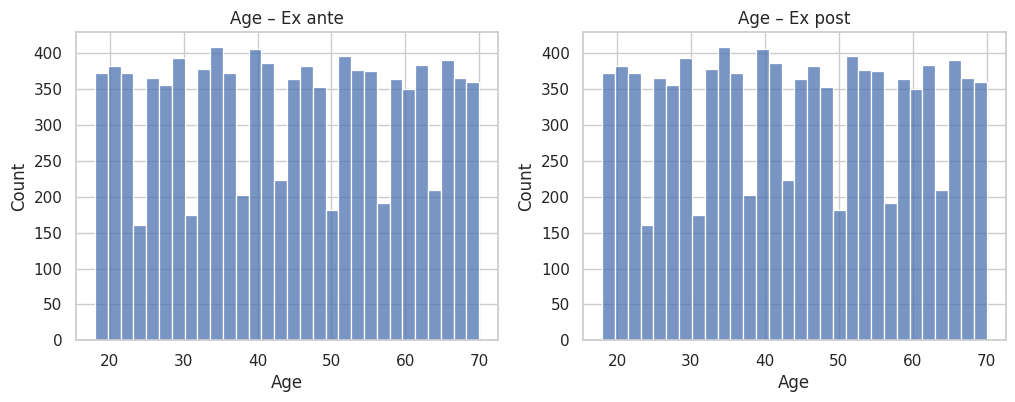

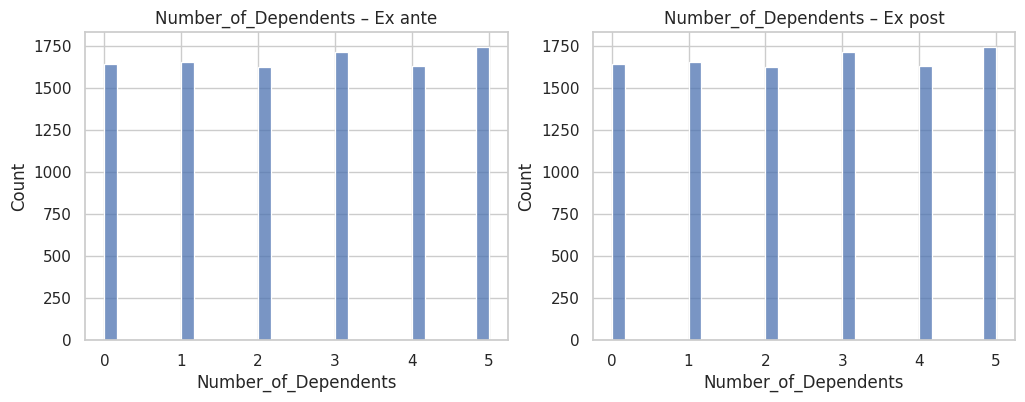

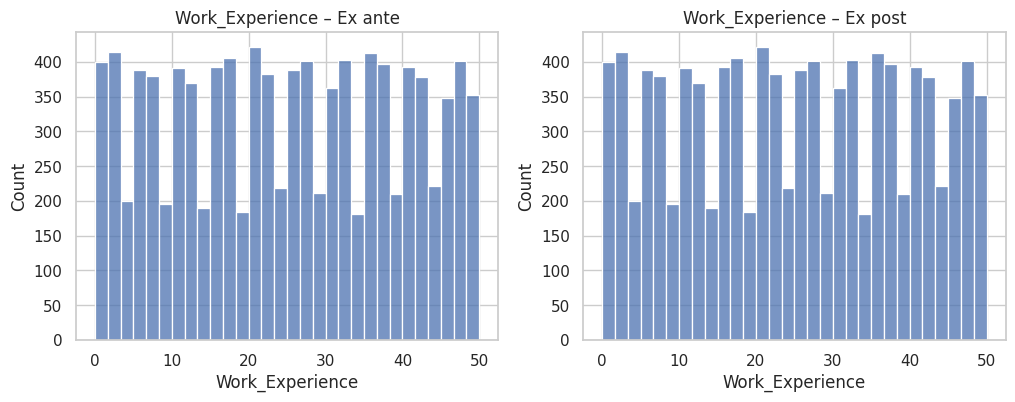

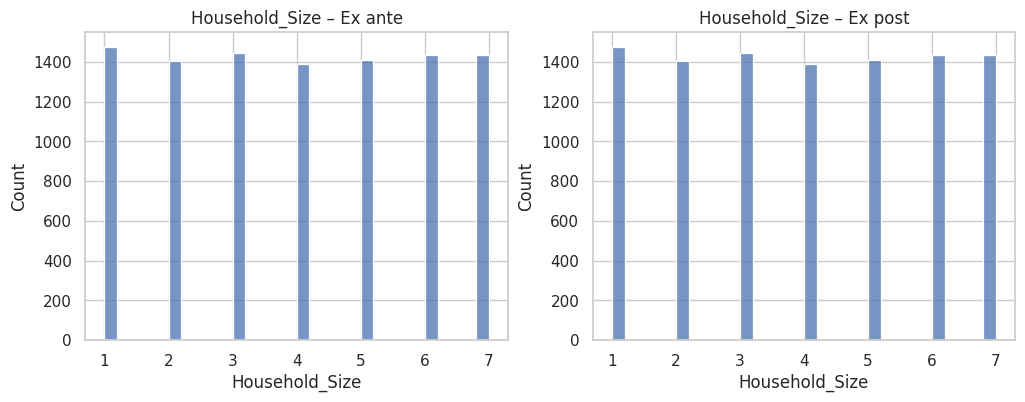

In [ ]:
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    sns.histplot(df_raw[col], bins=30, ax=ax[0])
    sns.histplot(df_prep[col], bins=30, ax=ax[1])

    ax[0].set_title(f"{col} – Ex ante")
    ax[1].set_title(f"{col} – Ex post")

    plt.show()

### **4.1.6 Boxplot**

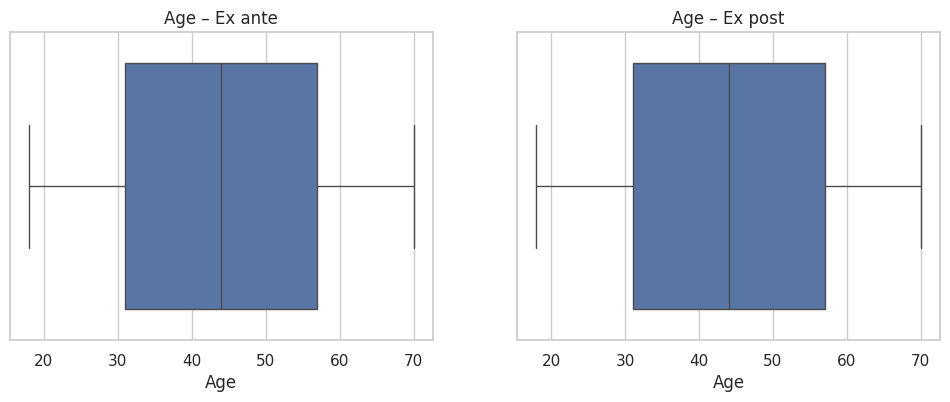

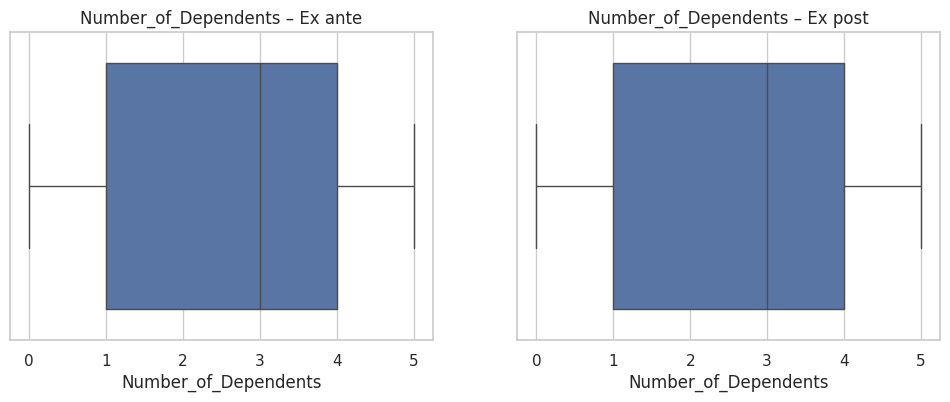

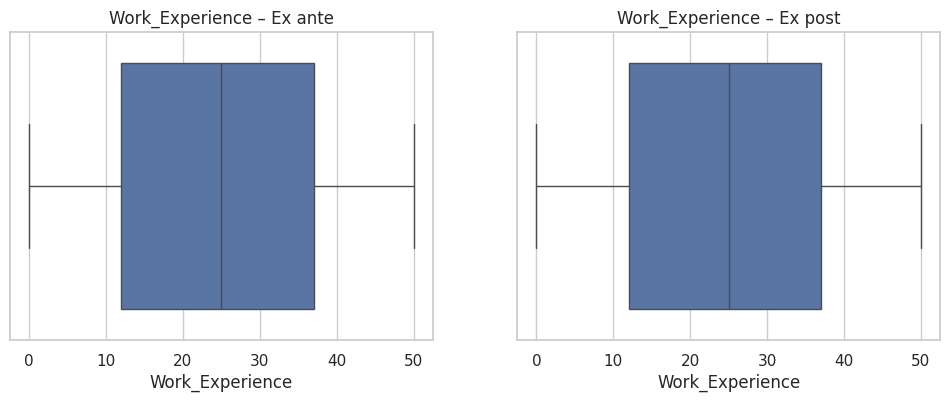

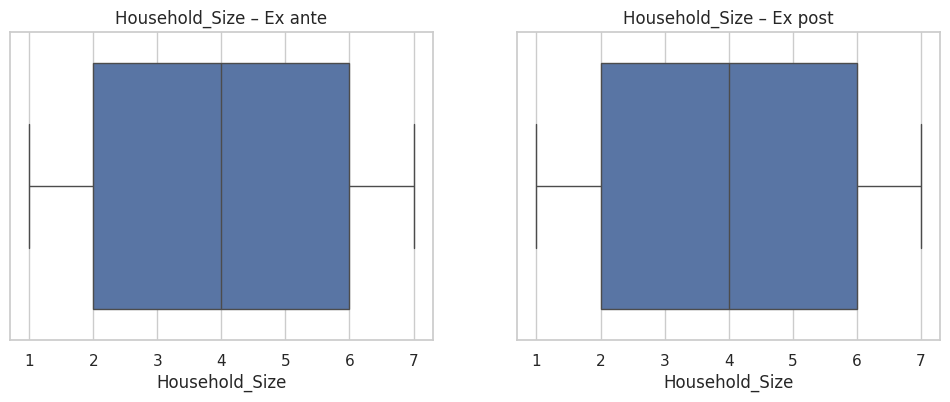

In [ ]:
for col in num_cols:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))

    sns.boxplot(x=df_raw[col], ax=ax[0])
    sns.boxplot(x=df_prep[col], ax=ax[1])

    ax[0].set_title(f"{col} – Ex ante")
    ax[1].set_title(f"{col} – Ex post")

    plt.show()

## **4.2 Variables categóricas**

### **4.2.1 Cardinalidad**

In [ ]:
card_raw = df_raw[cat_cols].nunique().to_frame("Ex ante")
card_prep = df_prep[cat_cols].nunique().to_frame("Ex post")

cardinality_compare = (
    card_raw
    .join(card_prep)
    .reset_index()
    .rename(columns={"index": "variable"})
)

display(
    cardinality_compare
    .style
    .hide(axis="index"))


variable,Ex ante,Ex post
Education_Level,4,4
Occupation,5,5
Location,3,3
Marital_Status,3,3
Employment_Status,3,3
Homeownership_Status,2,2
Type_of_Housing,3,3
Gender,2,2
Primary_Mode_of_Transportation,4,4


### **4.2.2 Top 10 valores más frecuentes**

In [ ]:
for col in cat_cols:
    print(f"\nTop 10 valores más frecuentes – {col}")

    # Normalizamos strings solo para el análisis comparativo
    raw_col = df_raw[col].astype(str).str.strip().str.lower()
    prep_col = df_prep[col].astype(str).str.strip().str.lower()

    # Definimos top 10 - Ex ante
    top_categories = raw_col.value_counts().head(10).index

    # Ex ante (%)
    raw_pct = (
        raw_col
        .value_counts(normalize=True)
        .mul(100)
        .reindex(top_categories)
    )

    # Ex post (%)
    prep_pct = (
        prep_col
        .value_counts(normalize=True)
        .mul(100)
        .reindex(top_categories)
    )

    # Consolidamos
    top10 = (
        pd.concat(
            [raw_pct, prep_pct],
            axis=1,
            keys=["Ex ante (%)", "Ex post (%)"]
        )
        .fillna(0)
        .round(2)
        .reset_index()
        .rename(columns={"index": col})
    )

    display(
        top10
        .style
        .hide(axis="index")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center")]}
        ])
        .format({
            "Ex ante (%)": "{:.2f}",
            "Ex post (%)": "{:.2f}"
        })
    )


Top 10 valores más frecuentes – Education_Level


Education_Level,Ex ante (%),Ex post (%)
bachelor's,40.58,40.58
high school,29.59,29.59
master's,24.82,24.82
doctorate,5.01,5.01



Top 10 valores más frecuentes – Occupation


Occupation,Ex ante (%),Ex post (%)
healthcare,30.35,30.35
technology,24.07,24.07
finance,15.25,15.25
others,15.21,15.21
education,15.12,15.12



Top 10 valores más frecuentes – Location


Location,Ex ante (%),Ex post (%)
urban,70.37,70.37
suburban,19.51,19.51
rural,10.12,10.12



Top 10 valores más frecuentes – Marital_Status


Marital_Status,Ex ante (%),Ex post (%)
married,51.36,51.36
single,39.00,39.00
divorced,9.64,9.64



Top 10 valores más frecuentes – Employment_Status


Employment_Status,Ex ante (%),Ex post (%)
full-time,50.04,50.04
part-time,30.16,30.16
self-employed,19.80,19.80



Top 10 valores más frecuentes – Homeownership_Status


Homeownership_Status,Ex ante (%),Ex post (%)
own,60.18,60.18
rent,39.82,39.82



Top 10 valores más frecuentes – Type_of_Housing


Type_of_Housing,Ex ante (%),Ex post (%)
single-family home,40.55,40.55
apartment,40.01,40.01
townhouse,19.44,19.44



Top 10 valores más frecuentes – Gender


Gender,Ex ante (%),Ex post (%)
male,51.23,51.23
female,48.77,48.77



Top 10 valores más frecuentes – Primary_Mode_of_Transportation


Primary_Mode_of_Transportation,Ex ante (%),Ex post (%)
public transit,40.47,40.47
car,29.86,29.86
biking,19.40,19.40
walking,10.27,10.27



Countplot Top 10 – Education_Level


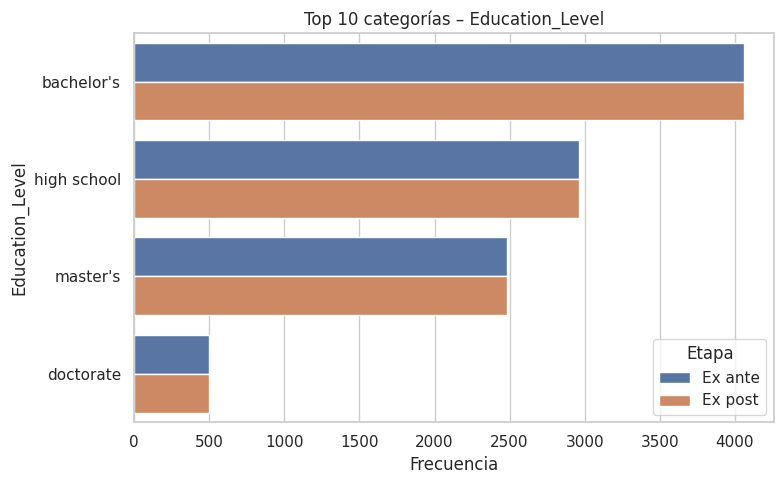


Countplot Top 10 – Occupation


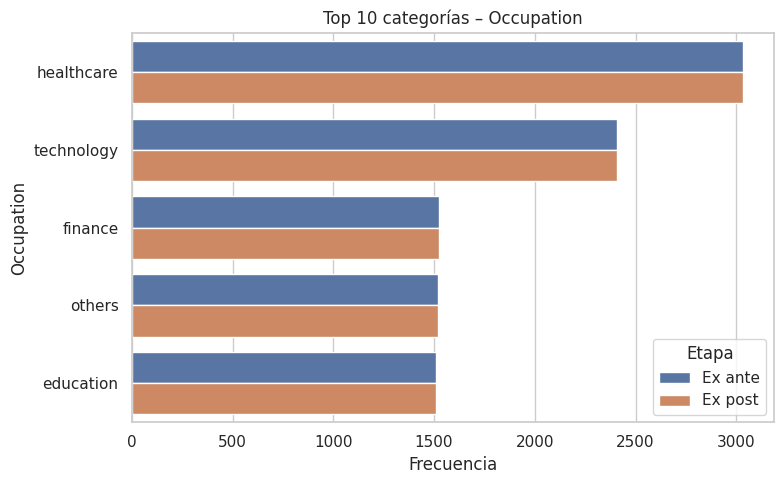


Countplot Top 10 – Location


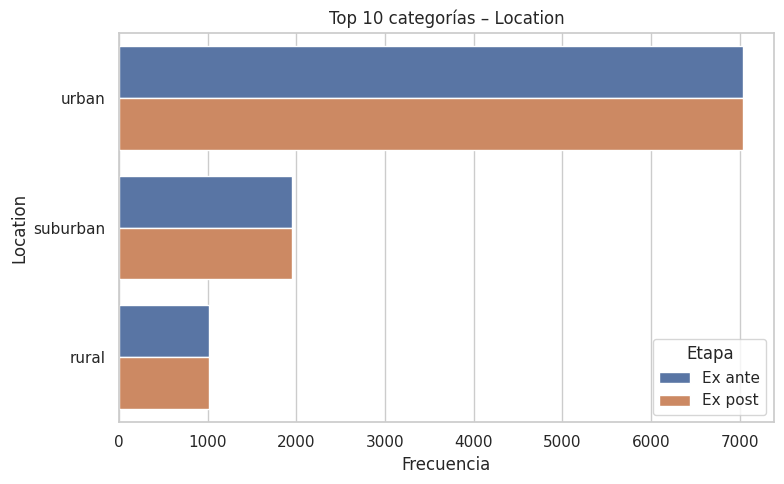


Countplot Top 10 – Marital_Status


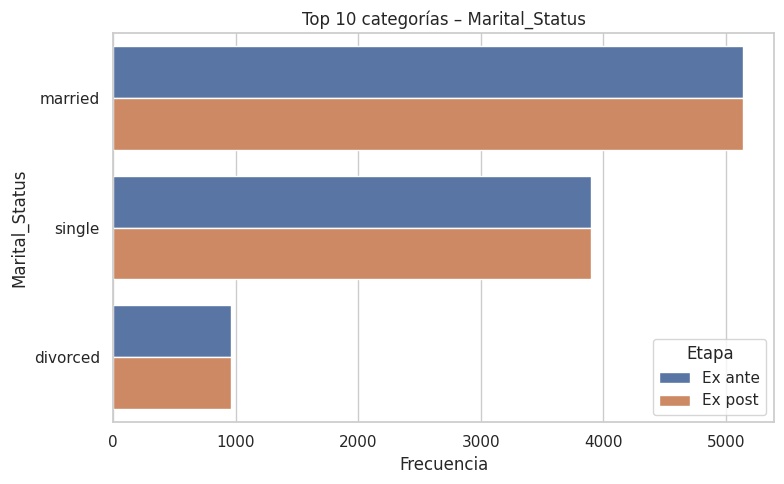


Countplot Top 10 – Employment_Status


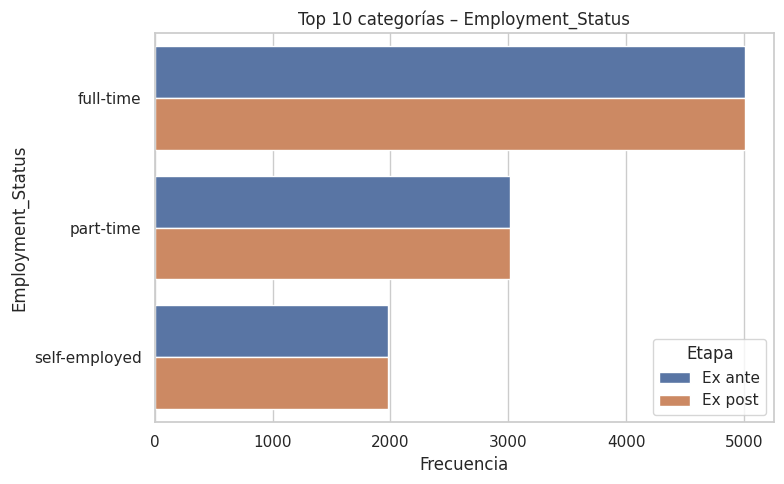


Countplot Top 10 – Homeownership_Status


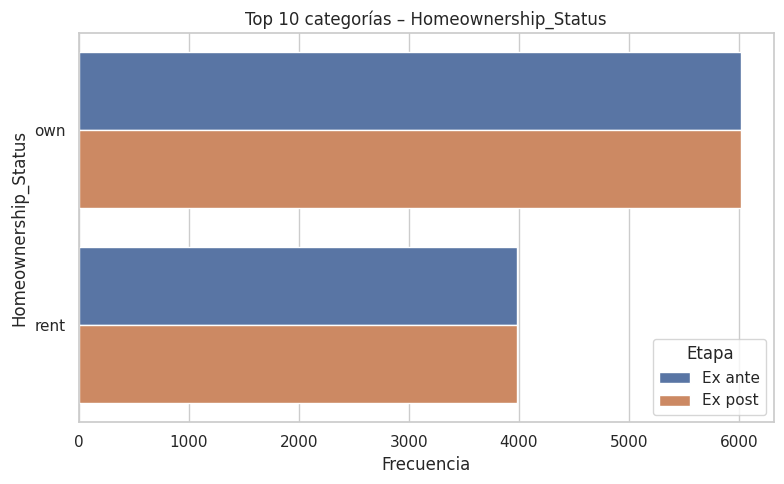


Countplot Top 10 – Type_of_Housing


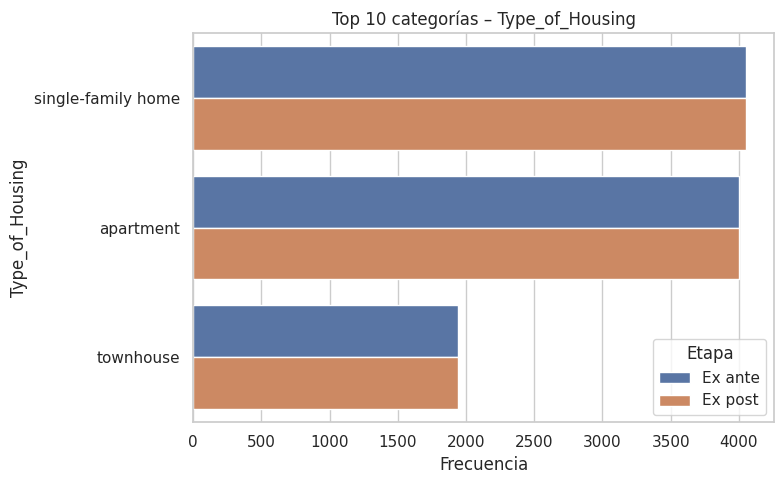


Countplot Top 10 – Gender


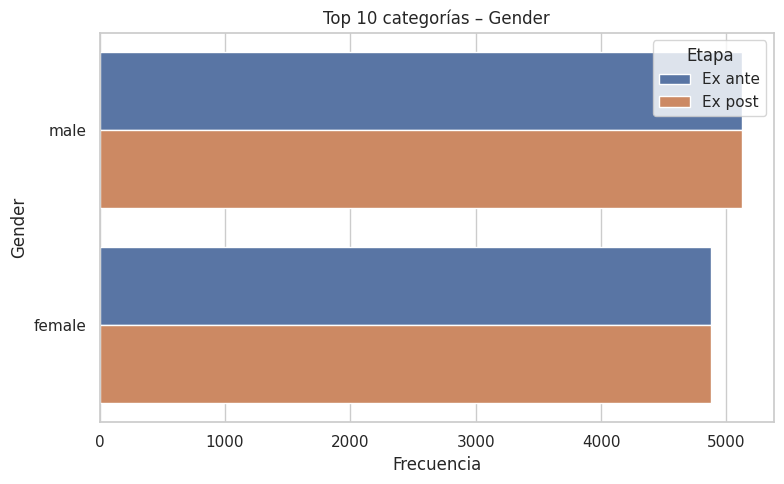


Countplot Top 10 – Primary_Mode_of_Transportation


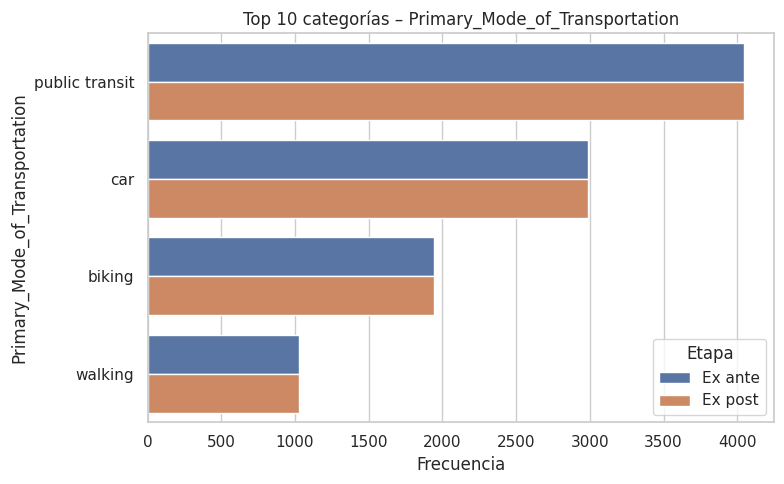

In [ ]:
#Countplot top 10

for col in cat_cols:
    print(f"\nCountplot Top 10 – {col}")

    # Normalizamos strings solo para análisis
    raw_col = df_raw[col].astype(str).str.strip().str.lower()
    prep_col = df_prep[col].astype(str).str.strip().str.lower()

    # Definimos top 10 Ex ante
    top_categories = raw_col.value_counts().head(10).index

    # Dataframe consolidado
    plot_df = pd.concat([
        pd.DataFrame({
            col: raw_col[raw_col.isin(top_categories)],
            "Etapa": "Ex ante"
        }),
        pd.DataFrame({
            col: prep_col[prep_col.isin(top_categories)],
            "Etapa": "Ex post"
        })
    ])

    plt.figure(figsize=(8, 5))
    sns.countplot(
        data=plot_df,
        y=col,
        hue="Etapa",
        order=top_categories
    )

    plt.title(f"Top 10 categorías – {col}")
    plt.xlabel("Frecuencia")
    plt.ylabel(col)
    plt.legend(title="Etapa")
    plt.tight_layout()
    plt.show()

### **4.2.3 Tabla de frecuencias**

In [ ]:
dominance = []

for col in cat_cols:
    raw_vc = df_raw[col].value_counts(normalize=True)
    prep_vc = df_prep[col].value_counts(normalize=True)

    dominance.append({
        "variable": col,
        "% top1 ex ante": raw_vc.iloc[0] * 100,
        "% top5 ex ante": raw_vc.iloc[:5].sum() * 100,
        "% top1 ex post": prep_vc.iloc[0] * 100,
        "% top5 ex post": prep_vc.iloc[:5].sum() * 100
    })

dominance_df = pd.DataFrame(dominance)
display(
    dominance_df
    .style
    .hide(axis="index")
    .format({"% top1 ex ante":"{:.2f}", "% top5 ex ante":"{:.0f}","% top1 ex post":"{:.2f}","% top5 ex post":"{:.0f}"}))


variable,% top1 ex ante,% top5 ex ante,% top1 ex post,% top5 ex post
Education_Level,40.58,100,40.58,100
Occupation,30.35,100,30.35,100
Location,70.37,100,70.37,100
Marital_Status,51.36,100,51.36,100
Employment_Status,50.04,100,50.04,100
Homeownership_Status,60.18,100,60.18,100
Type_of_Housing,40.55,100,40.55,100
Gender,51.23,100,51.23,100
Primary_Mode_of_Transportation,40.47,100,40.47,100


In [ ]:
summary_rows = []

for col in cat_cols:

    # Normalizamos strings solo para análisis
    raw_col = df_raw[col].astype(str).str.strip().str.lower()
    prep_col = df_prep[col].astype(str).str.strip().str.lower()

    # Distribuciones relativas
    raw_dist = raw_col.value_counts(normalize=True).mul(100)
    prep_dist = prep_col.value_counts(normalize=True).mul(100)

    summary_rows.append({
        "Variable": col,
        "% Top 1 Ex ante": raw_dist.iloc[0],
        "% Top 5 Ex ante": raw_dist.iloc[:5].sum(),
        "% Top 1 Ex post": prep_dist.iloc[0],
        "% Top 5 Ex post": prep_dist.iloc[:5].sum()
    })

top_summary_df = pd.DataFrame(summary_rows)

top_summary_df.iloc[:, 1:] = top_summary_df.iloc[:, 1:].round(2)

display(
    top_summary_df
    .style
    .hide(axis="index")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]}
    ])
    .format({
        "% Top 1 Ex ante": "{:.2f}",
        "% Top 5 Ex ante": "{:.2f}",
        "% Top 1 Ex post": "{:.2f}",
        "% Top 5 Ex post": "{:.2f}"
    })
)

Variable,% Top 1 Ex ante,% Top 5 Ex ante,% Top 1 Ex post,% Top 5 Ex post
Education_Level,40.58,100.00,40.58,100.00
Occupation,30.35,100.00,30.35,100.00
Location,70.37,100.00,70.37,100.00
Marital_Status,51.36,100.00,51.36,100.00
Employment_Status,50.04,100.00,50.04,100.00
Homeownership_Status,60.18,100.00,60.18,100.00
Type_of_Housing,40.55,100.00,40.55,100.00
Gender,51.23,100.00,51.23,100.00
Primary_Mode_of_Transportation,40.47,100.00,40.47,100.00


Un 100% en % top 5  de todas las variables demuestra que total de la muestra está cubierta por por las 5 categorías más frecuentes, esto se confirma ya que que ninguna de las variables tiene más de 5 categorías.

# **5. EDA bivariado: Variables Explicativas vs Target**

## **5.1. Para Regresión**

### **Variables numéricas vs Target**

### **5.1.1 Boxplot por Buckets**

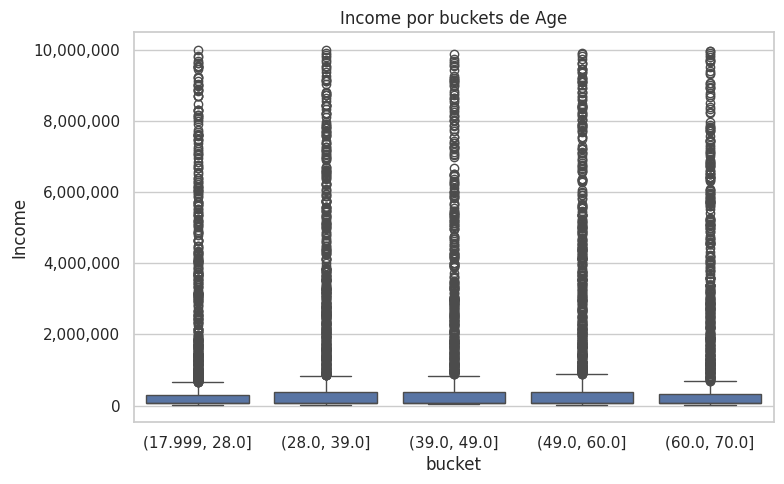

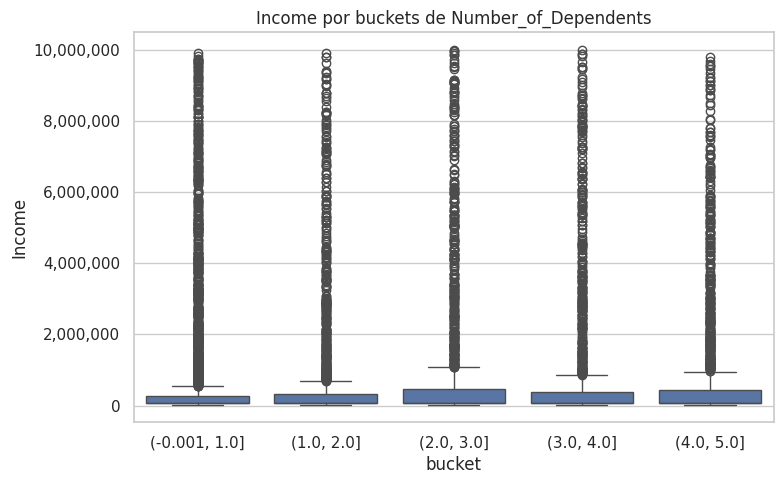

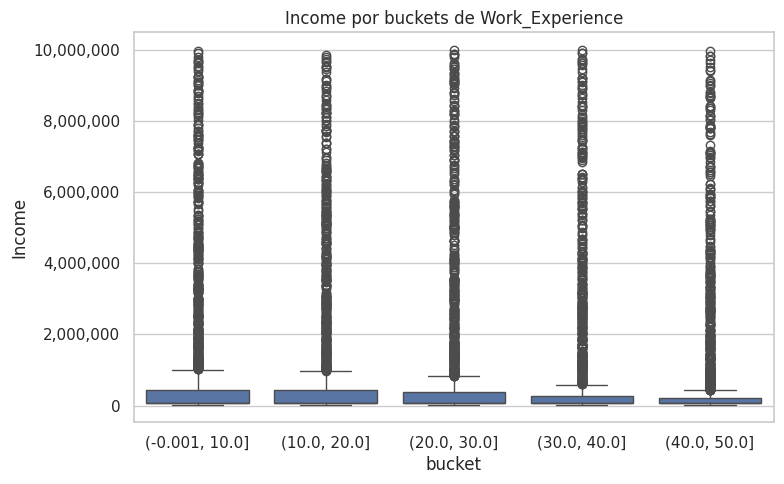

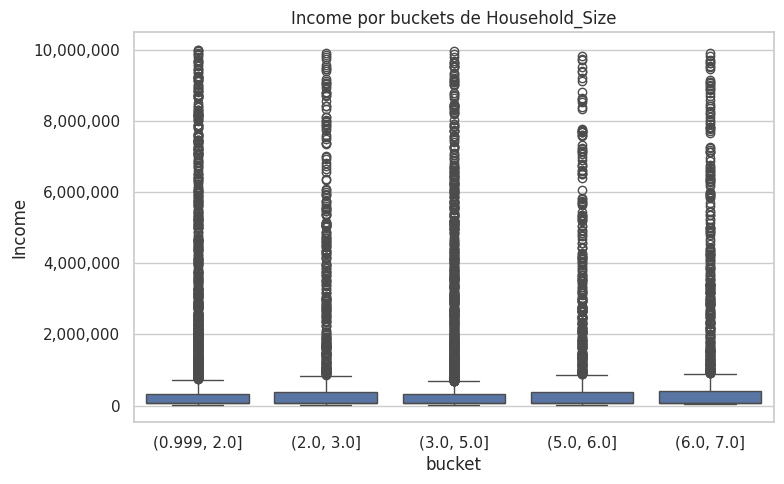

In [ ]:
def boxplot_target_by_numeric_buckets(df, num_col, target, q=5):
    temp = df[[num_col, target]].dropna().copy()

    if temp[num_col].nunique() < q:
        print(f"{num_col}: pocos valores únicos para {q} buckets")
        return

    temp["bucket"] = pd.qcut(temp[num_col], q=q, duplicates="drop")

    plt.figure(figsize=(8, 5))
    sns.boxplot(x="bucket", y=target, data=temp)
    plt.xticks(rotation=0)
    plt.title(f"{target} por buckets de {num_col}")

    # 👇 FORMATO REAL DEL EJE Y
    plt.gca().yaxis.set_major_formatter(
        mtick.StrMethodFormatter('{x:,.0f}')
    )

    plt.tight_layout()
    plt.show()

for col in num_cols:
  if col != target:
      boxplot_target_by_numeric_buckets(df, col, target)

### **5.1.2 Target por Buckets**

In [ ]:
q = 5

for col in num_cols:
    if col == target:
        continue

    temp = df[[col, target]].dropna().copy()

    if temp[col].nunique() < q:
        print(f"{col}: pocos valores únicos para {q} buckets")
        continue

    # Buckets
    temp["bucket"] = pd.qcut(temp[col], q=q, duplicates="drop")

    # groupby explícito + observed=True
    mean_target = temp.groupby("bucket", observed=True)[target].mean()
    median_target = temp.groupby("bucket", observed=True)[target].median()
    n_bucket = temp.groupby("bucket", observed=True).size()

    # Tabla final
    bucket_table = pd.concat(
        [n_bucket, mean_target, median_target],
        axis=1
    ).reset_index()

    bucket_table.columns = ["bucket", "n", "mean", "median"]

    bucket_table["mean"] = bucket_table["mean"].round(0).astype(int)
    bucket_table["median"] = bucket_table["median"].round(0).astype(int)

    print(f"\nTARGET POR BUCKETS — {col}")
    display(bucket_table)


TARGET POR BUCKETS — Age


,bucket,n,mean,median
0,"(17.999, 28.0]",2009,769555,72900
1,"(28.0, 39.0]",2126,853466,72897
2,"(39.0, 49.0]",1920,775719,73028
3,"(49.0, 60.0]",2047,864689,73216
4,"(60.0, 70.0]",1898,815848,72748



TARGET POR BUCKETS — Number_of_Dependents


,bucket,n,mean,median
0,"(-0.001, 1.0]",3293,786151,72664
1,"(1.0, 2.0]",1621,783512,72882
2,"(2.0, 3.0]",1712,884785,73070
3,"(3.0, 4.0]",1629,858914,73228
4,"(4.0, 5.0]",1745,799766,73162



TARGET POR BUCKETS — Work_Experience


,bucket,n,mean,median
0,"(-0.001, 10.0]",2179,857509,73552
1,"(10.0, 20.0]",1941,885261,73562
2,"(20.0, 30.0]",2002,847045,73023
3,"(30.0, 40.0]",1987,771140,72598
4,"(40.0, 50.0]",1891,715779,72156



TARGET POR BUCKETS — Household_Size


,bucket,n,mean,median
0,"(0.999, 2.0]",2883,851129,72892
1,"(2.0, 3.0]",1445,834775,73230
2,"(3.0, 5.0]",2802,798475,73002
3,"(5.0, 6.0]",1437,731661,72736
4,"(6.0, 7.0]",1433,851083,73038


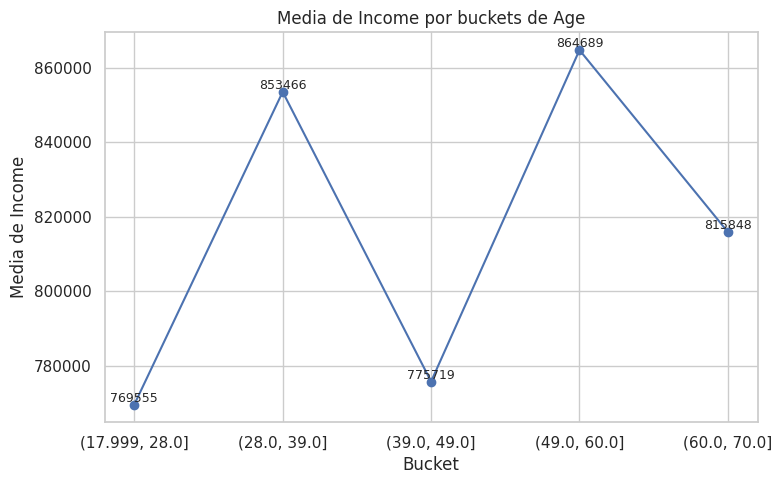

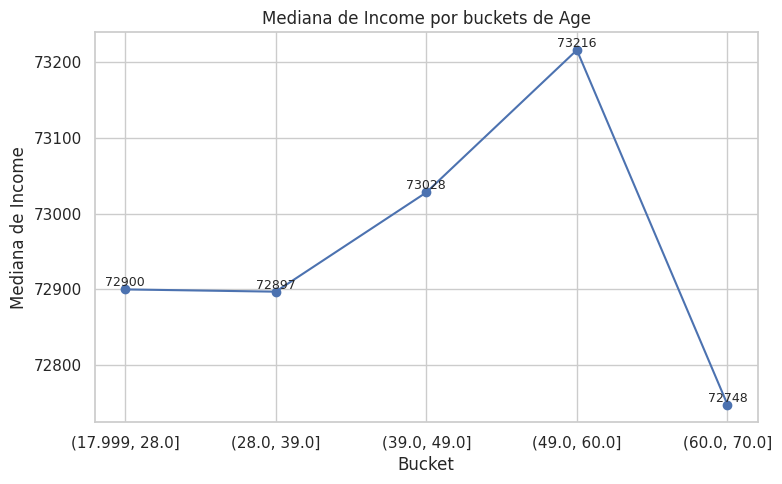

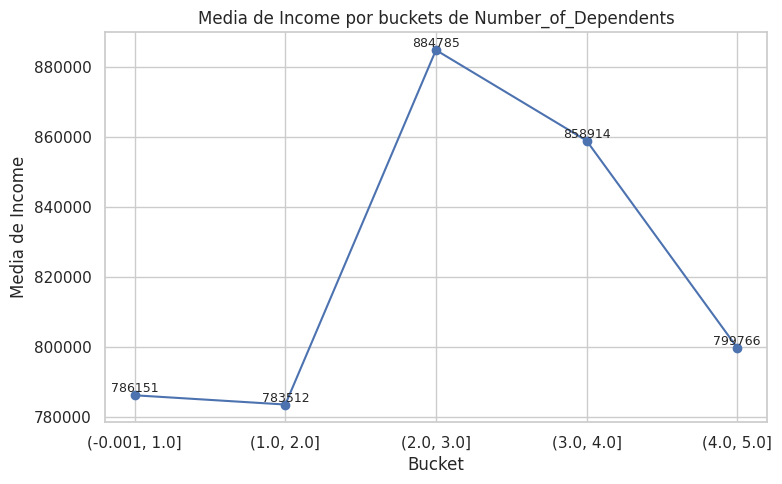

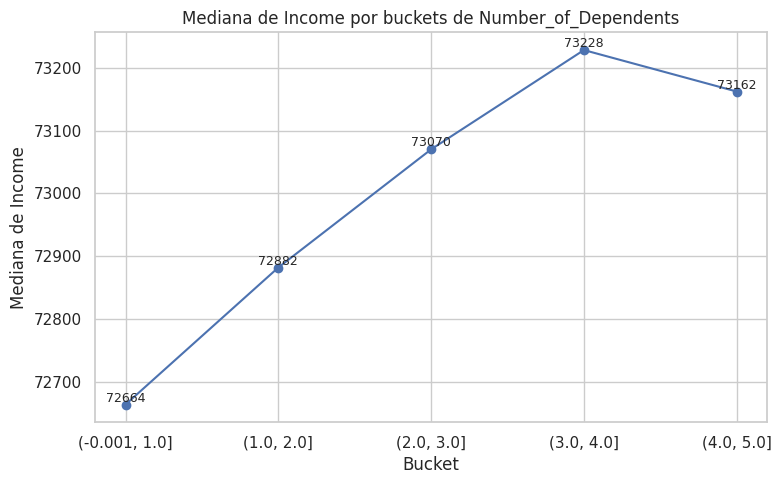

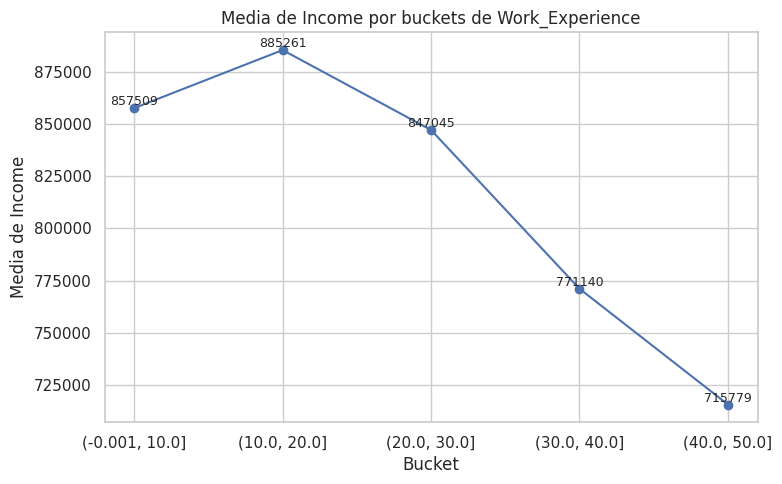

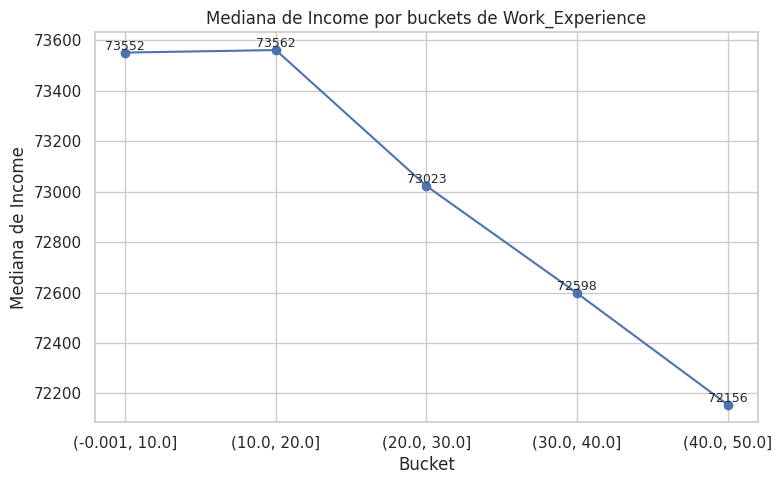

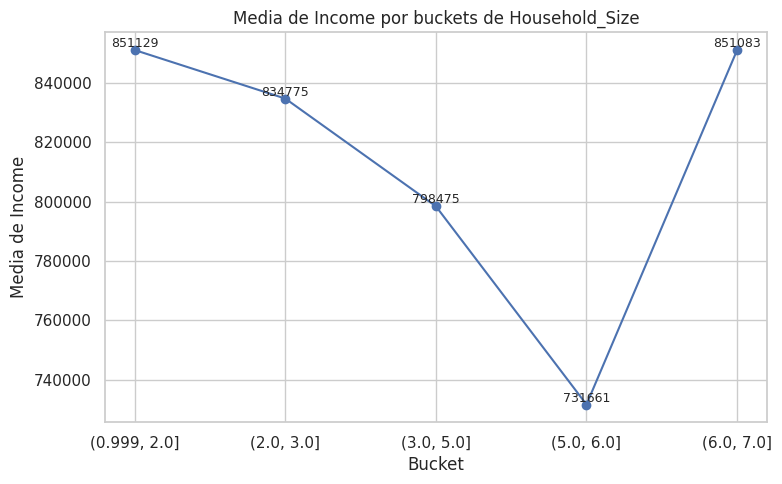

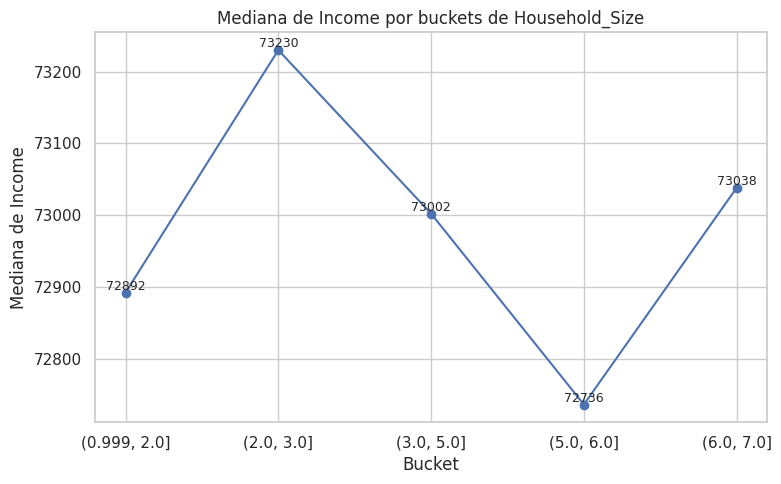

In [ ]:
q = 5  # número de buckets

for col in num_cols:
    if col == target:
        continue

    temp = df[[col, target]].dropna().copy()

    if temp[col].nunique() < q:
        print(f"{col}: pocos valores únicos para {q} buckets")
        continue

    # Buckets sobre la variable explicativa
    temp["bucket"] = pd.qcut(temp[col], q=q, duplicates="drop")

    # Estadísticos del target por bucket
    mean_target = temp.groupby("bucket", observed=True)[target].mean()
    median_target = temp.groupby("bucket", observed=True)[target].median()
    n_bucket = temp.groupby("bucket", observed=True).size()

    bucket_table = pd.concat(
        [n_bucket, mean_target, median_target],
        axis=1
    ).reset_index()

    bucket_table.columns = ["bucket", "n", "mean", "median"]

    bucket_table["mean"] = bucket_table["mean"].round(0).astype(int)
    bucket_table["median"] = bucket_table["median"].round(0).astype(int)

    x = bucket_table["bucket"].astype(str)

    # Gráfico 1: MEDIA
    plt.figure(figsize=(8, 5))
    plt.plot(x, bucket_table["mean"], marker="o")

    for i in range(len(x)):
        plt.text(i, bucket_table["mean"].iloc[i],
                 f"{bucket_table['mean'].iloc[i]}",
                 ha="center", va="bottom", fontsize=9)

    plt.title(f"Media de {target} por buckets de {col}")
    plt.xlabel("Bucket")
    plt.ylabel(f"Media de {target}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # Gráfico 2: MEDIANA
    plt.figure(figsize=(8, 5))
    plt.plot(x, bucket_table["median"], marker="o")

    for i in range(len(x)):
        plt.text(i, bucket_table["median"].iloc[i],
                 f"{bucket_table['median'].iloc[i]}",
                 ha="center", va="bottom", fontsize=9)

    plt.title(f"Mediana de {target} por buckets de {col}")
    plt.xlabel("Bucket")
    plt.ylabel(f"Mediana de {target}")
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [ ]:
def evaluar_tendencia_suave(valores):
    diffs = np.diff(valores)
    positivos = np.sum(diffs > 0)
    negativos = np.sum(diffs < 0)

    if positivos > negativos:
        return "Tendencia general creciente"
    elif negativos > positivos:
        return "Tendencia general decreciente"
    else:
        return "Sin tendencia clara / no monotónica"


In [ ]:
for col in num_cols:
    if col == target:
        continue

    temp = df[[col, target]].dropna().copy()

    if temp[col].nunique() < q:
        continue

    temp["bucket"] = pd.qcut(temp[col], q=q, duplicates="drop")

    bucket_table = temp.groupby("bucket", observed=True)[target] \
                       .median() \
                       .reset_index(name="median")

    bucket_table["median"] = bucket_table["median"].round(0).astype(int)

    tendencia = evaluar_tendencia_suave(bucket_table["median"].values)

    print(f"Tendencia ({col}): {tendencia}")


Tendencia (Age): Sin tendencia clara / no monotónica
Tendencia (Number_of_Dependents): Tendencia general creciente
Tendencia (Work_Experience): Tendencia general decreciente
Tendencia (Household_Size): Sin tendencia clara / no monotónica


### **Variables categóricas vs Target**

### **5.2.1 Target medio por categoría**

In [ ]:
for col in cat_cols:
    temp = df[[col, target]].dropna()

    summary = temp.groupby(col)[target] \
                  .agg(["mean", "median"]) \
                  .reset_index()

    summary["mean"] = summary["mean"].round(0).astype(int)
    summary["median"] = summary["median"].round(0).astype(int)

    print(f"\nTARGET POR CATEGORÍA — {col}")
    display(
        summary
        .style
        .hide(axis="index")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center")]}
        ]))



TARGET POR CATEGORÍA — Education_Level


Education_Level,mean,median
Bachelor's,812336,72888
Doctorate,628711,71346
High School,868667,73452
Master's,800383,72747



TARGET POR CATEGORÍA — Occupation


Occupation,mean,median
Education,920817,73317
Finance,706153,72228
Healthcare,799239,73146
Others,828970,73428
Technology,836174,72650



TARGET POR CATEGORÍA — Location


Location,mean,median
Rural,1050473,74815
Suburban,921399,73198
Urban,754250,72664



TARGET POR CATEGORÍA — Marital_Status


Marital_Status,mean,median
Divorced,780831,73112
Married,839260,72919
Single,796211,72936



TARGET POR CATEGORÍA — Employment_Status


Employment_Status,mean,median
Full-time,780895,72812
Part-time,905303,73512
Self-employed,772924,72616



TARGET POR CATEGORÍA — Homeownership_Status


Homeownership_Status,mean,median
Own,724168,71921
Rent,956890,75328



TARGET POR CATEGORÍA — Type_of_Housing


Type_of_Housing,mean,median
Apartment,873188,73556
Single-family home,793627,72658
Townhouse,749280,72575



TARGET POR CATEGORÍA — Gender


Gender,mean,median
Female,820978,72800
Male,812897,73100



TARGET POR CATEGORÍA — Primary_Mode_of_Transportation


Primary_Mode_of_Transportation,mean,median
Biking,848860,73242
Car,783156,72937
Public transit,823185,72834
Walking,829271,72956


### **5.2.2 Registros por categoría**

In [ ]:
for col in cat_cols:
    temp = df[col].dropna()

    counts = temp.value_counts().reset_index()
    counts.columns = [col, "n"]
    counts["%"] = (counts["n"] / counts["n"].sum() * 100).round(2)

    print(f"\nREGISTROS POR CATEGORÍA — {col}")
    display(
        counts
        .style
        .hide(axis="index")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center")]}
        ])
        .format({"%":"{:.2f}"}))



REGISTROS POR CATEGORÍA — Education_Level


Education_Level,n,%
Bachelor's,4058,40.58
High School,2959,29.59
Master's,2482,24.82
Doctorate,501,5.01



REGISTROS POR CATEGORÍA — Occupation


Occupation,n,%
Healthcare,3035,30.35
Technology,2407,24.07
Finance,1525,15.25
Others,1521,15.21
Education,1512,15.12



REGISTROS POR CATEGORÍA — Location


Location,n,%
Urban,7037,70.37
Suburban,1951,19.51
Rural,1012,10.12



REGISTROS POR CATEGORÍA — Marital_Status


Marital_Status,n,%
Married,5136,51.36
Single,3900,39.00
Divorced,964,9.64



REGISTROS POR CATEGORÍA — Employment_Status


Employment_Status,n,%
Full-time,5004,50.04
Part-time,3016,30.16
Self-employed,1980,19.80



REGISTROS POR CATEGORÍA — Homeownership_Status


Homeownership_Status,n,%
Own,6018,60.18
Rent,3982,39.82



REGISTROS POR CATEGORÍA — Type_of_Housing


Type_of_Housing,n,%
Single-family home,4055,40.55
Apartment,4001,40.01
Townhouse,1944,19.44



REGISTROS POR CATEGORÍA — Gender


Gender,n,%
Male,5123,51.23
Female,4877,48.77



REGISTROS POR CATEGORÍA — Primary_Mode_of_Transportation


Primary_Mode_of_Transportation,n,%
Public transit,4047,40.47
Car,2986,29.86
Biking,1940,19.40
Walking,1027,10.27


### **5.2.3 Dispersión por categoría**

In [ ]:
#Tabla de dispersión
for col in cat_cols:
    temp = df[[col, target]].dropna()

    dispersion = temp.groupby(col)[target] \
                     .quantile([0.25, 0.75]) \
                     .unstack() \
                     .reset_index()

    dispersion.columns = [col, "p25", "p75"]

    dispersion["p25"] = dispersion["p25"].round(0).astype(int)
    dispersion["p75"] = dispersion["p75"].round(0).astype(int)

    print(f"\nDISPERSIÓN DEL TARGET — {col}")
    display(
        dispersion
        .style
        .hide(axis="index")
        .set_properties(**{"text-align": "center"})
        .set_table_styles([
            {"selector": "th", "props": [("text-align", "center")]}
        ]))



DISPERSIÓN DEL TARGET — Education_Level


Education_Level,p25,p75
Bachelor's,68377,367942
Doctorate,67538,75392
High School,68677,444736
Master's,68390,315053



DISPERSIÓN DEL TARGET — Occupation


Occupation,p25,p75
Education,68717,553278
Finance,68126,185614
Healthcare,68657,372318
Others,68404,412832
Technology,68215,289960



DISPERSIÓN DEL TARGET — Location


Location,p25,p75
Rural,68882,837698
Suburban,68630,492754
Urban,68326,271029



DISPERSIÓN DEL TARGET — Marital_Status


Marital_Status,p25,p75
Divorced,68514,366790
Married,68456,347739
Single,68404,345555



DISPERSIÓN DEL TARGET — Employment_Status


Employment_Status,p25,p75
Full-time,68316,342163
Part-time,68758,451588
Self-employed,68273,241292



DISPERSIÓN DEL TARGET — Homeownership_Status


Homeownership_Status,p25,p75
Own,68034,111405
Rent,69268,727809



DISPERSIÓN DEL TARGET — Type_of_Housing


Type_of_Housing,p25,p75
Apartment,68666,446952
Single-family home,68194,316629
Townhouse,68452,213670



DISPERSIÓN DEL TARGET — Gender


Gender,p25,p75
Female,68326,331574
Male,68545,373394



DISPERSIÓN DEL TARGET — Primary_Mode_of_Transportation


Primary_Mode_of_Transportation,p25,p75
Biking,68486,372420
Car,68448,331347
Public transit,68514,345720
Walking,68146,395270


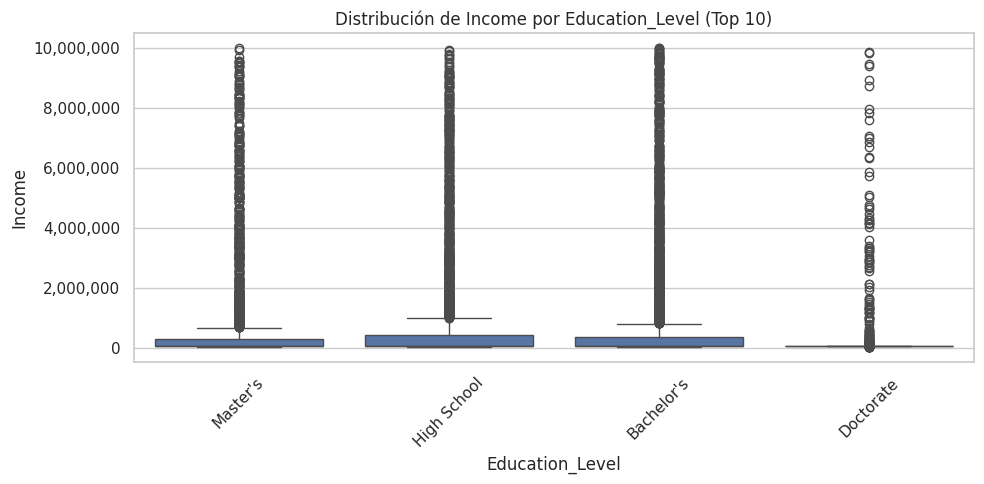

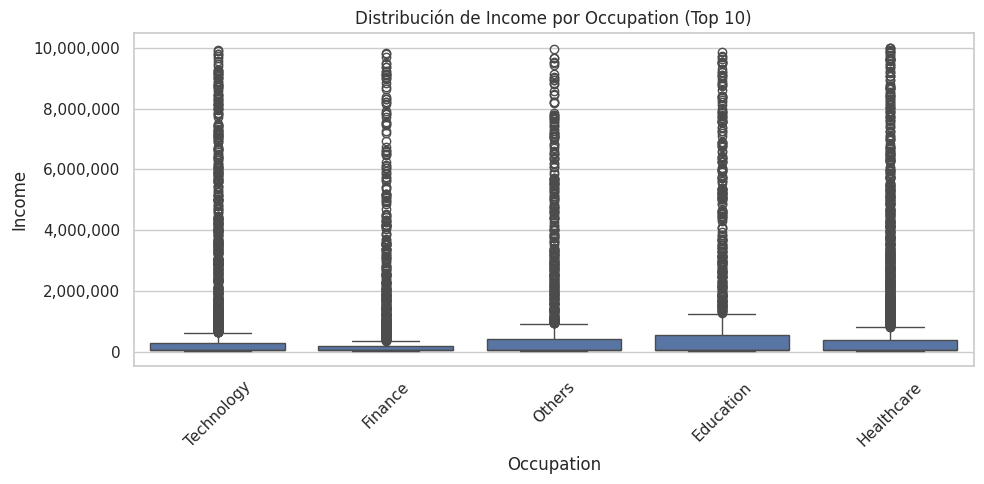

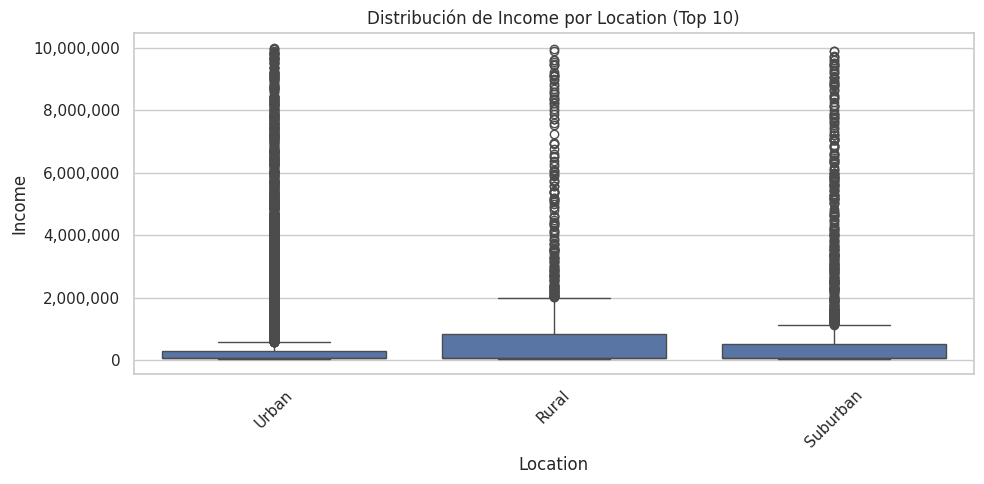

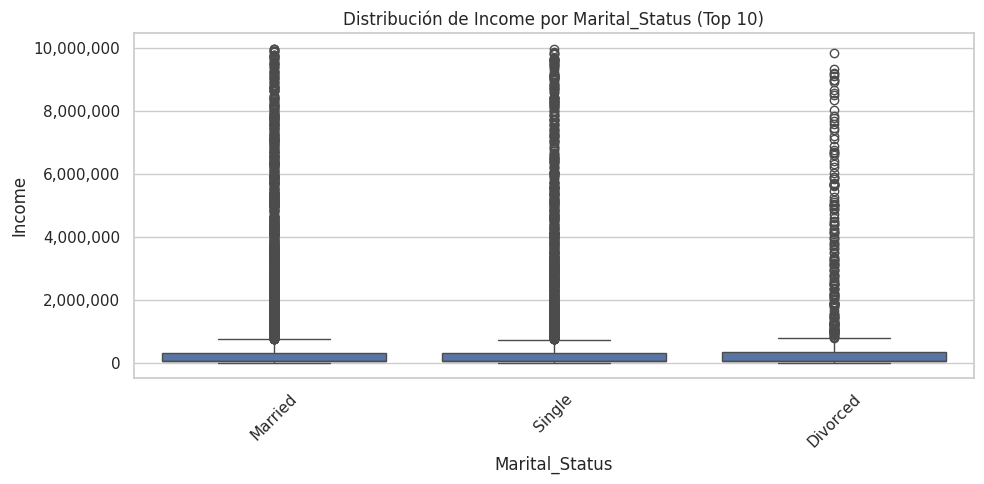

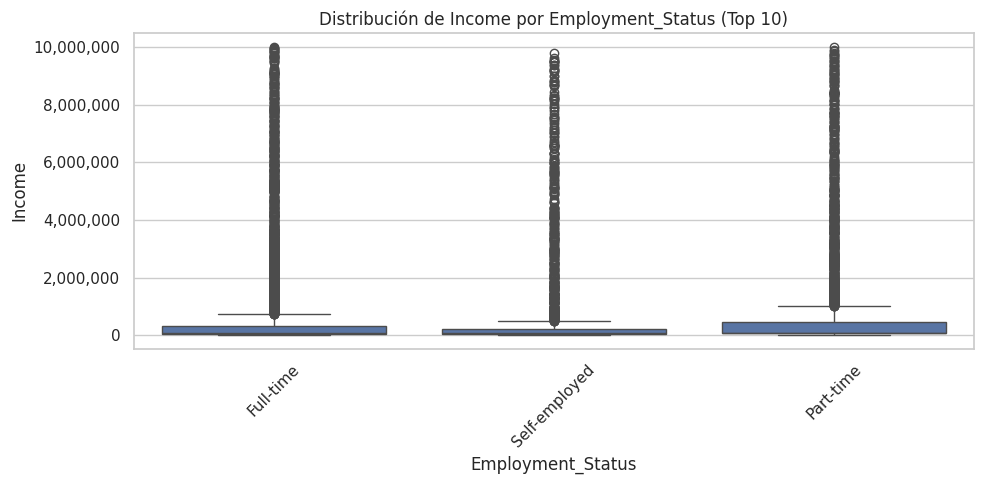

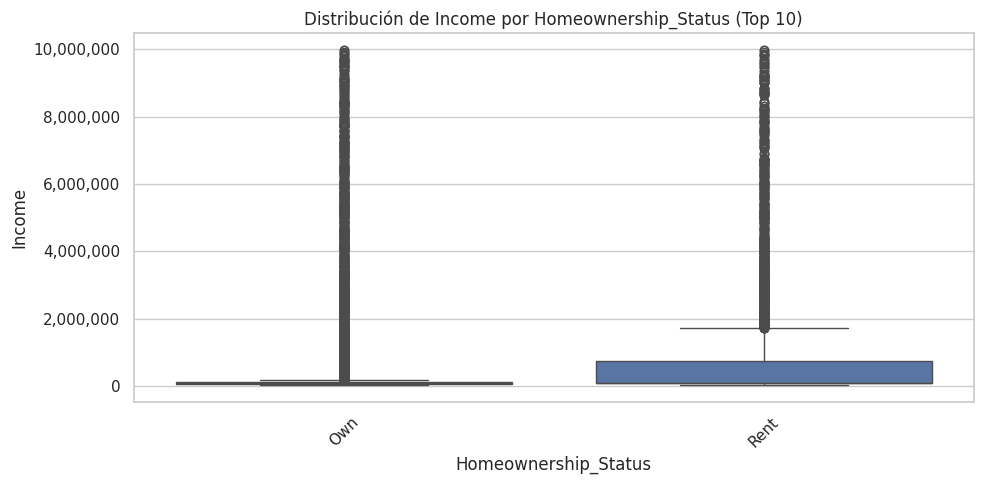

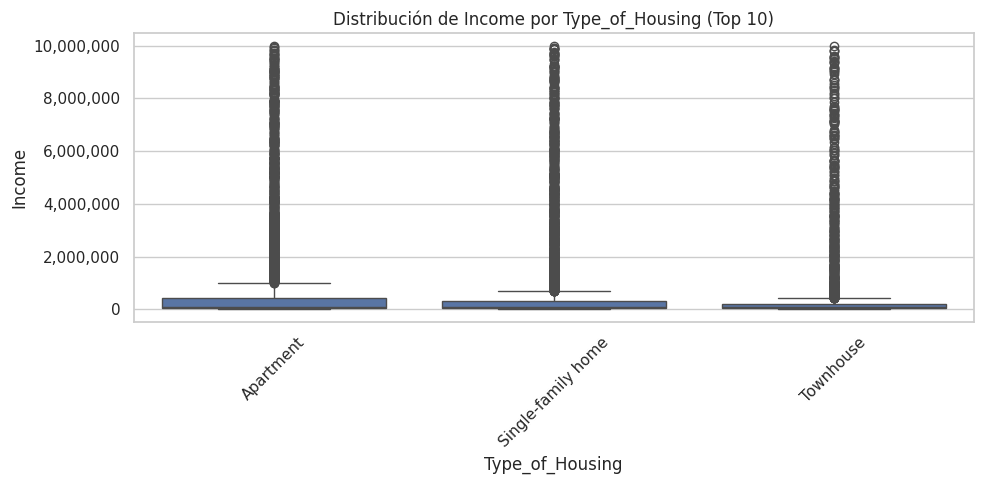

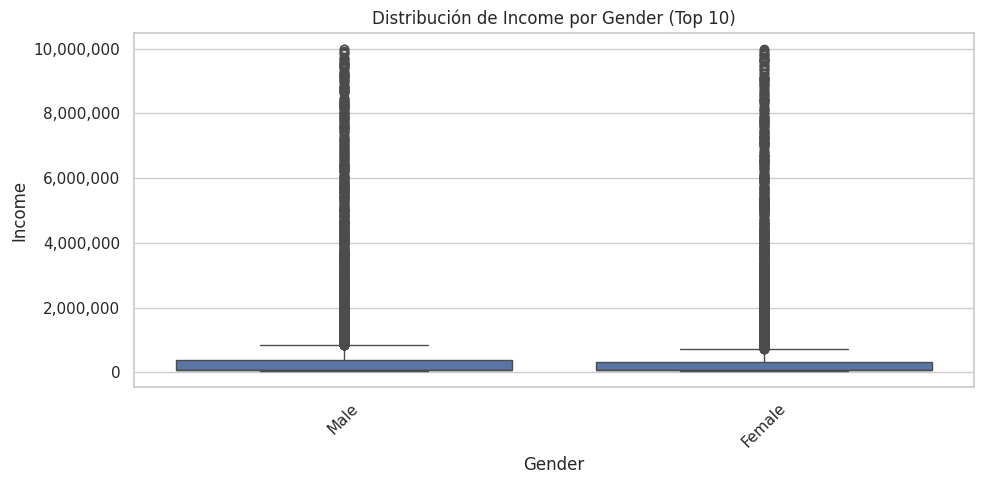

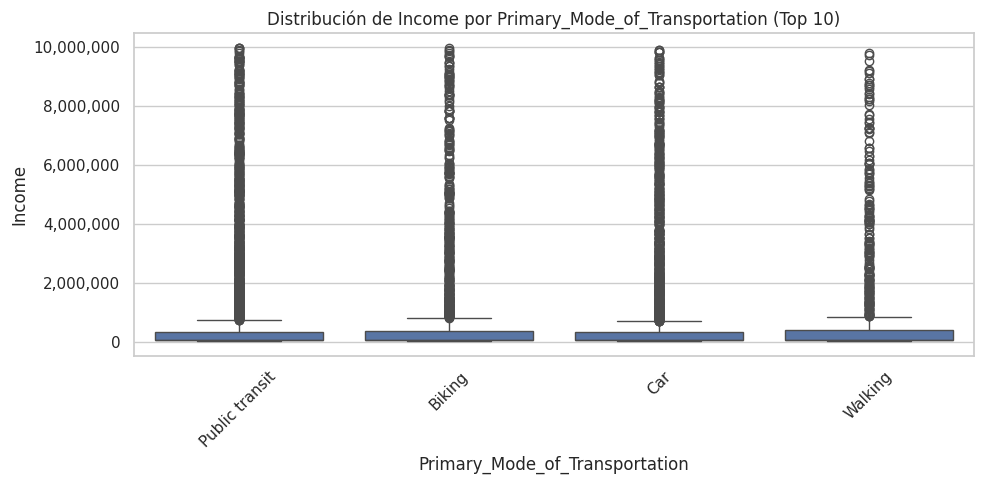

In [ ]:
#Boxplot por categoría

top_k = 10  # número de categorías más frecuentes a graficar

for col in cat_cols:
    temp = df[[col, target]].dropna()

    # Seleccionar top-k categorías por frecuencia
    top_categories = temp[col].value_counts().head(top_k).index
    temp_top = temp[temp[col].isin(top_categories)]

    plt.figure(figsize=(10, 5))
    ax = sns.boxplot(data=temp_top, x=col, y=target)

    # 🔹 FIX CLAVE: formato correcto del eje Y
    ax.yaxis.set_major_formatter(
        ticker.StrMethodFormatter('{x:,.0f}')
    )

    plt.title(f"Distribución de {target} por {col} (Top {top_k})")
    plt.xlabel(col)
    plt.ylabel(target)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()